In [ ]:
!pip install segmentation_models_pytorch
!pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=9471049d9fac2c9e83b67d025e61b8e835da30c2ee1b8d011d175285880167f4
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=2fffbc45dcc32fd4f7356281481f3f8d97162973791f79ae2593db58eb1f9045
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [ ]:
!pip install ml_collections

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ml_collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94506 sha256=d9f079511d6418a6bd5abb1a235b72af51579ac0a297b40dec9dd354763550dc
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
Successfully built ml_collections


In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
import os
import time
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

import cv2

from glob import glob

import segmentation_models_pytorch as smp
import albumentations as A

import warnings
warnings.simplefilter("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Preprocessing data

In [ ]:
chase_db = '/content/drive/MyDrive/Vessels-Datasets/ChaseDB/Train/Original'
drive = '/content/drive/MyDrive/Vessels-Datasets/DRIVE/Train/Original'
hrf = '/content/drive/MyDrive/Vessels-Datasets/HRF/Train/Original'

In [ ]:
def get_random_crop(image, mask, crop_h, crop_w):
  assert len(image.shape) == 3

  max_w = image.shape[1] - crop_w
  max_h = image.shape[0] - crop_h

  x = np.random.randint(0, max_w)
  y = np.random.randint(0, max_h)

  crop_image = image[y: y + crop_h, x: x + crop_w, :]
  crop_mask = mask[y: y + crop_h, x: x + crop_w, :]

  return crop_image, crop_mask

In [ ]:
datasets = {'DRIVE': drive, 'ChaseDB': chase_db, 'HRF': hrf}

SAVED_PATH = '/content/drive/MyDrive/Vessels_Dataset_Preprocessing_3/'

for dataset_name, dataset_path in datasets.items():
  save_pth_images = f'{SAVED_PATH}/{dataset_name}/Images'
  save_pth_masks = f'{SAVED_PATH}/{dataset_name}/Labels'

  os.makedirs(save_pth_images, exist_ok=True)
  os.makedirs(save_pth_masks, exist_ok=True)

  IMAGE_PATH = f'{dataset_path}/Images'
  MASK_PATH = f'{dataset_path}/Labels'

  for image in os.listdir(IMAGE_PATH):
    print(dataset_name, image)
    image_pth = f'{IMAGE_PATH}/{image}'
    label_pth = f'{MASK_PATH}/{image}' if dataset_name != 'HRF' else f"{MASK_PATH}/{image.split('.')[0]}.tif"

    image_ = cv2.imread(image_pth)
    mask_ = cv2.imread(label_pth)
    for i in range(10):
      image_crop, mask_crop = get_random_crop(image_, mask_, 256, 256)
      cv2.imwrite(f"{save_pth_images}/{image.split('.')[0]}_{i}.png", image_crop)
      cv2.imwrite(f"{save_pth_masks}/{image.split('.')[0]}_{i}.png", mask_crop)

    if max(image_.shape[:2]) / min(image_.shape[:2]) < 1.5:
      image_full = cv2.resize(image_, (256, 256), interpolation=cv2.INTER_LANCZOS4)
      mask_full = cv2.resize(mask_, (256, 256), interpolation=cv2.INTER_LANCZOS4)
      cv2.imwrite(f"{save_pth_images}/{image}", image_crop)
      cv2.imwrite(f"{save_pth_masks}/{image}", mask_crop)

DRIVE 27.jpg
DRIVE 36.jpg
DRIVE 39.jpg
DRIVE 33.jpg
DRIVE 34.jpg
DRIVE 32.jpg
DRIVE 25.jpg
DRIVE 38.jpg
DRIVE 21.jpg
DRIVE 30.jpg
DRIVE 26.jpg
DRIVE 29.jpg
DRIVE 24.jpg
DRIVE 37.jpg
DRIVE 23.jpg
DRIVE 22.jpg
DRIVE 28.jpg
DRIVE 35.jpg
DRIVE 40.jpg
DRIVE 31.jpg
ChaseDB 2.jpg
ChaseDB 14.jpg
ChaseDB 4.jpg
ChaseDB 1.jpg
ChaseDB 12.jpg
ChaseDB 7.jpg
ChaseDB 16.jpg
ChaseDB 10.jpg
ChaseDB 20.jpg
ChaseDB 9.jpg
ChaseDB 18.jpg
ChaseDB 17.jpg
ChaseDB 13.jpg
ChaseDB 8.jpg
ChaseDB 5.jpg
ChaseDB 15.jpg
ChaseDB 6.jpg
ChaseDB 11.jpg
ChaseDB 3.jpg
ChaseDB 19.jpg
HRF 104.jpg
HRF 101.jpg
HRF 105.jpg
HRF 103.jpg
HRF 85.jpg
HRF 87.jpg
HRF 102.jpg
HRF 86.jpg
HRF 84.jpg
HRF 83.jpg
HRF 90.jpg
HRF 89.jpg
HRF 88.jpg
HRF 82.jpg
HRF 81.jpg


In [ ]:
drive = '/content/drive/MyDrive/Vessels-Datasets/DRIVE/Test/Original'
hrf = '/content/drive/MyDrive/Vessels-Datasets/HRF/Test/Original'

datasets = {'DRIVE': drive, 'HRF': hrf}

SAVED_PATH = '/content/drive/MyDrive/Vessels_Dataset_Preprocessing_3/'

for dataset_name, dataset_path in datasets.items():
  save_pth_images = f'{SAVED_PATH}/{dataset_name}/Images'
  save_pth_masks = f'{SAVED_PATH}/{dataset_name}/Labels'

  os.makedirs(save_pth_images, exist_ok=True)
  os.makedirs(save_pth_masks, exist_ok=True)

  IMAGE_PATH = f'{dataset_path}/Images'
  MASK_PATH = f'{dataset_path}/Labels'

  for image in os.listdir(IMAGE_PATH)[:10]:
    print(dataset_name, image)
    image_pth = f'{IMAGE_PATH}/{image}'
    label_pth = f'{MASK_PATH}/{image}' if dataset_name != 'HRF' else f"{MASK_PATH}/{image.split('.')[0]}.tif"

    image_ = cv2.imread(image_pth)
    mask_ = cv2.imread(label_pth)
    for i in range(10):
      image_crop, mask_crop = get_random_crop(image_, mask_, 256, 256)
      cv2.imwrite(f"{save_pth_images}/{image.split('.')[0]}_{i}.png", image_crop)
      cv2.imwrite(f"{save_pth_masks}/{image.split('.')[0]}_{i}.png", mask_crop)

    if max(image_.shape[:2]) / min(image_.shape[:2]) < 1.5:
      image_full = cv2.resize(image_, (256, 256), interpolation=cv2.INTER_LANCZOS4)
      mask_full = cv2.resize(mask_, (256, 256), interpolation=cv2.INTER_LANCZOS4)
      cv2.imwrite(f"{save_pth_images}/{image}", image_crop)
      cv2.imwrite(f"{save_pth_masks}/{image}", mask_crop)

DRIVE 06.jpg
DRIVE 13.jpg
DRIVE 05.jpg
DRIVE 10.jpg
DRIVE 17.jpg
DRIVE 03.jpg
DRIVE 19.jpg
DRIVE 07.jpg
DRIVE 14.jpg
DRIVE 04.jpg
HRF 73.jpg
HRF 100.jpg
HRF 71.jpg
HRF 62.jpg
HRF 68.jpg
HRF 95.jpg
HRF 76.jpg
HRF 75.jpg
HRF 67.jpg
HRF 64.jpg


In [ ]:
train_images = [
    '06.jpg',
    '13.jpg',
    '05.jpg',
    '10.jpg',
    '17.jpg',
    '03.jpg',
    '19.jpg',
    '07.jpg',
    '14.jpg',
    '04.jpg',
    '73.jpg',
    '100.jpg',
    '71.jpg',
    '62.jpg',
    '68.jpg',
    '95.jpg',
    '76.jpg',
    '75.jpg',
    '67.jpg',
    '64.jpg'
]

drive = '/content/drive/MyDrive/Vessels-Datasets/DRIVE/Test/Original'
hrf = '/content/drive/MyDrive/Vessels-Datasets/HRF/Test/Original'

SAVED_PATH = '/content/drive/MyDrive/VesseslTest/'
os.makedirs(SAVED_PATH, exist_ok=True)

datasets = {'DRIVE': drive, 'HRF': hrf}

for dataset_name, dataset_path in datasets.items():
  save_pth_images = f'{SAVED_PATH}/{dataset_name}/Images'
  save_pth_masks = f'{SAVED_PATH}/{dataset_name}/Labels'

  os.makedirs(save_pth_images, exist_ok=True)
  os.makedirs(save_pth_masks, exist_ok=True)

  IMAGE_PATH = f'{dataset_path}/Images'
  MASK_PATH = f'{dataset_path}/Labels'

  for image in os.listdir(IMAGE_PATH):
    if image in train_images: continue
    print(dataset_name, image)

    image_pth = f'{IMAGE_PATH}/{image}'
    label_pth = f'{MASK_PATH}/{image}' if dataset_name != 'HRF' else f"{MASK_PATH}/{image.split('.')[0]}.tif"

    image_ = cv2.imread(image_pth)
    mask_ = cv2.imread(label_pth)

    cv2.imwrite(f"{save_pth_images}/{image.split('.')[0]}.png", image_)
    cv2.imwrite(f"{save_pth_masks}/{image.split('.')[0]}.png", mask_)

DRIVE 15.jpg
DRIVE 18.jpg
DRIVE 09.jpg
DRIVE 02.jpg
DRIVE 08.jpg
DRIVE 20.jpg
DRIVE 11.jpg
DRIVE 12.jpg
DRIVE 01.jpg
DRIVE 16.jpg
HRF 97.jpg
HRF 65.jpg
HRF 94.jpg
HRF 98.jpg
HRF 96.jpg
HRF 63.jpg
HRF 70.jpg
HRF 79.jpg
HRF 92.jpg
HRF 74.jpg
HRF 99.jpg
HRF 77.jpg
HRF 72.jpg
HRF 80.jpg
HRF 93.jpg
HRF 69.jpg
HRF 78.jpg
HRF 61.jpg
HRF 66.jpg
HRF 91.jpg


#Write utility code

In [ ]:
class DriveDataset(Dataset):
  def __init__(self, images_path, masks_path, is_val):

    self.images_path = images_path
    self.masks_path = masks_path
    self._is_val = is_val
    self.n_samples = len(images_path)

  def _random_flip(self, image, mask):
    random_flip = np.random.randint(-1, 2)

    image = cv2.flip(image, random_flip)
    mask = cv2.flip(mask, random_flip)

    return image, mask

  def __getitem__(self, index):
    is_augment = np.random.random() if not self._is_val else 0

    image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0

    mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
    mask = mask / 255.0

    if is_augment > 0.5:
      image, mask = self._random_flip(image, mask)

    if len(mask.shape) != 2:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    image = np.transpose(image, (2, 0, 1))
    image = image.astype(np.float32)
    image = torch.from_numpy(image)

    mask = np.expand_dims(mask, axis=0)
    mask = mask.astype(np.float32)
    mask = torch.from_numpy(mask)

    return image, mask

  def __len__(self):
    return self.n_samples

In [ ]:
class DiceLoss(nn.Module):
  def __init__(self, eps = 1e-9):
    super(DiceLoss, self).__init__()
    self.eps = eps

  def forward(self, inputs, targets):
    inputs = torch.sigmoid(inputs)

    inputs = inputs.view(-1)
    targets = targets.view(-1)

    inter = (inputs * targets).sum()
    union = inputs.sum() + targets.sum()

    dice = (2*inter + self.eps) / (union + self.eps)

    return 1 - dice

class BCEDiceLoss(nn.Module):
  def __init__(self):
    super(BCEDiceLoss, self).__init__()
    self.bce = nn.BCEWithLogitsLoss()
    self.dice = DiceLoss()

  def forward(self, inputs, targets):
    dice_loss = self.dice(inputs, targets)
    bce_loss = self.bce(inputs, targets)

    return bce_loss + dice_loss

class IoULoss(nn.Module):
  def __init__(self, weight=None, size_average=True):
    super(IoULoss, self).__init__()

  def forward(self, inputs, targets, smooth=1):

    inputs = torch.sigmoid(inputs)

    inputs = inputs.view(-1)
    targets = targets.view(-1)

    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection

    IoU = (intersection + smooth)/(union + smooth)

    return 1 - IoU

class JaccardBCELoss(nn.Module):
  def __init__(self):
    super(JaccardBCELoss, self).__init__()
    self.bce = nn.BCEWithLogitsLoss()
    self.jaccard = IoULoss()

  def forward(self, inputs, targets):
    jaccard_loss = self.jaccard(inputs, targets)
    bce_loss = self.bce(inputs, targets)

    return bce_loss + jaccard_loss

class FocalLoss(nn.Module):
  def __init__(self):
    super(FocalLoss, self).__init__()

  def forward(self, inputs, targets, alpha=0.8, gamma=2.0, smooth=1):
    inputs = torch.sigmoid(inputs)

    inputs = inputs.view(-1)
    targets = targets.view(-1)

    BCE = nn.functional.binary_cross_entropy(inputs, targets)
    BCE_EXP = torch.exp(-BCE)
    focal_loss = alpha*(1-BCE_EXP)**gamma * BCE

    return focal_loss

class JaccardDiceLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.dice = DiceLoss()
    self.jaccard = IoULoss()

  def forward(self, inputs, targets):
    jaccard_loss = self.jaccard(inputs, targets)
    dice_loss = self.dice(inputs, targets)

    return dice_loss + jaccard_loss

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score
from operator import add

def calculate_metrics(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    y_pred = y_pred.cpu().numpy()
    y_pred_auc = y_pred.reshape(-1)
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    specificity = tn / (tn+fp)
    sensitivity = tp / (tp + fn)
    score_auc = roc_auc_score(y_true, y_pred_auc)
    score_f1 = 2*tp/(2*tp+fn+fp)
    score_acc = (tp + tn) / (tp + tn + fn + fp)

    return [specificity, sensitivity, score_auc, score_f1, score_acc]

In [ ]:
def train(net, loader, opt, loss, device, cutout_prob=0.5, scheduler=None):
  net.train()
  epoch_loss = 0.0
  count = 0
  for x, y in loader:
    opt.zero_grad()

    x = x.to(device, dtype=torch.float32)
    y = y.to(device, dtype=torch.float32)

    preds = net.forward(x)
    loss_value = loss(preds, y)
    loss_value.backward()
    opt.step()
    epoch_loss += loss_value.item()

  if scheduler != None:
    scheduler.step()
  epoch_loss = epoch_loss/len(loader)
  return epoch_loss


def evaluate(net, loader, loss, device):
  net.eval()
  epoch_loss = 0.0
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.float32)

      preds = net.forward(x)
      loss_value = loss(preds, y)

      epoch_loss += loss_value.item()
    epoch_loss = epoch_loss/len(loader)

  return epoch_loss

def score(model, loader, device):
  model.eval()
  metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
  for x, y in loader:
    with torch.no_grad():
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.float32)

      preds = model(x)
      preds = torch.sigmoid(preds)

      score = calculate_metrics(y, preds)
      metrics_score = list(map(add, metrics_score, score))

  for i in range(len(metrics_score)):
    metrics_score[i] /= len(loader)

  return metrics_score

In [ ]:
def train_2(net, loader, opt, seg_loss, rec_loss, device, cutout_prob=0.5, scheduler=None):
  net.train()
  epoch_loss = 0.0
  count = 0
  for x, y in loader:
    opt.zero_grad()

    x = x.to(device, dtype=torch.float32)
    y = y.to(device, dtype=torch.float32)

    x_rec, x_seg = net.forward(x)
    rec_value = rec_loss(x_rec, x)
    seg_value = seg_loss(x_seg, y)
    loss_value = 0.1*rec_value + seg_value
    loss_value.backward()
    opt.step()
    epoch_loss += loss_value.item()

  if scheduler != None:
    scheduler.step()
  epoch_loss = epoch_loss/len(loader)
  return epoch_loss


def evaluate_2(net, loader, seg_loss, rec_loss, device):
  net.eval()
  epoch_loss = 0.0
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.float32)

      x_rec, x_seg = net.forward(x)
      rec_value = rec_loss(x_rec, x)
      seg_value = seg_loss(x_seg, y)
      loss_value = 0.5*rec_value + seg_value

      epoch_loss += loss_value.item()
    epoch_loss = epoch_loss/len(loader)

  return epoch_loss

def PSNR(target, predicted):
  mse = ((target - predicted) ** 2).mean()

  if mse == 0:
    return 100

  psnr = 10 * torch.log10(255.0 / mse)

  return psnr

def score_2(model, loader, device):
  model.eval()
  metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
  score_psnr = 0
  for x, y in loader:
    with torch.no_grad():
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.float32)

      x_rec, x_seg = model(x)
      x_seg = torch.sigmoid(x_seg)

      score = calculate_metrics(y, x_seg)
      metrics_score = list(map(add, metrics_score, score))

      score_psnr += PSNR(x, x_rec)

  metrics_score.append(score_psnr)
  for i in range(len(metrics_score)):
    metrics_score[i] /= len(loader)

  return metrics_score

In [ ]:
import math
from sklearn.externals._packaging.version import PrePostDevType
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def test(model, model_name, folder):
  model.eval()
  predicted = []
  test_x = sorted(glob(f"{folder}/Images/*"))
  test_y = sorted(glob(f"{folder}/Labels/*"))
  test_dataset = DriveDataset(test_x, test_y, is_val=True)
  test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4
  )

  metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
  for x, y in test_loader:
    with torch.no_grad():
      mask = torch.zeros(y.shape).to('cuda')
      y_pred = torch.zeros(y.shape).to('cuda')

      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.float32)
      crop_count_h = int(math.ceil(y.shape[2] / 224))
      crop_count_w = int(math.ceil(y.shape[3] / 224))
      for i in range(crop_count_h):
        crop_h = i * 224
        for j in range(crop_count_w):
          crop_w = j * 224
          if crop_w + 224 > y.shape[3]:
            crop_w = y.shape[3] - 224
          if crop_h + 224 > y.shape[2]:
            crop_h = y.shape[2] - 224

          pred = model(x[:, :, crop_h: crop_h + 224, crop_w: crop_w + 224])
          pred = torch.sigmoid(pred)
          y_pred[:, :, crop_h: crop_h + 224, crop_w: crop_w + 224] += pred
          mask[:, :, crop_h: crop_h + 224, crop_w: crop_w + 224] += torch.tensor(1)
      y_pred = y_pred / mask
      score = calculate_metrics(y, y_pred)
      metrics_score = list(map(add, metrics_score, score))
      predicted.append(y_pred)

  specificity = metrics_score[0]/len(test_loader)
  sensitivity = metrics_score[1]/len(test_loader)
  auc = metrics_score[2]/len(test_loader)
  f1 = metrics_score[3]/len(test_loader)
  acc = metrics_score[4]/len(test_loader)
  print(f'Model name: {model_name}')
  print(f'Specificity: {np.round(specificity, 4)}')
  print(f'Sensitivity: {np.round(sensitivity, 4)}')
  print(f'AUC ROC: {np.round(auc, 4)}')
  print(f'F1: {np.round(f1, 4)}')
  print(f'Accuracy: {np.round(acc, 4)}')

  return specificity, sensitivity, auc, f1, acc, predicted

In [ ]:
import math
from sklearn.externals._packaging.version import PrePostDevType
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def test2(model, model_name, folder):
  model.eval()
  predicted = []
  rec_predicted = []
  test_x = sorted(glob(f"{folder}/Images/*"))
  test_y = sorted(glob(f"{folder}/Labels/*"))
  test_dataset = DriveDataset(test_x, test_y, is_val=True)
  test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4
  )

  metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
  score_psnr = 0.0
  for x, y in test_loader:
    with torch.no_grad():
      mask = torch.zeros(y.shape).to('cuda')
      y_pred = torch.zeros(y.shape).to('cuda')
      rec_pred = torch.zeros(x.shape).to('cuda')

      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.float32)
      crop_count_h = int(math.ceil(y.shape[2] / 224))
      crop_count_w = int(math.ceil(y.shape[3] / 224))
      for i in range(crop_count_h):
        crop_h = i * 224
        for j in range(crop_count_w):
          crop_w = j * 224
          if crop_w + 224 > y.shape[3]:
            crop_w = y.shape[3] - 224
          if crop_h + 224 > y.shape[2]:
            crop_h = y.shape[2] - 224

          pred_rec, pred = model(x[:, :, crop_h: crop_h + 224, crop_w: crop_w + 224])
          pred = torch.sigmoid(pred)
          y_pred[:, :, crop_h: crop_h + 224, crop_w: crop_w + 224] += pred
          rec_pred[:, :, crop_h : crop_h + 224, crop_w : crop_w + 224] += pred_rec
          mask[:, :, crop_h: crop_h + 224, crop_w: crop_w + 224] += torch.tensor(1)

      y_pred = y_pred / mask
      rec_pred = rec_pred / mask
      score = calculate_metrics(y, y_pred)
      metrics_score = list(map(add, metrics_score, score))
      score_psnr += PSNR(x, rec_pred)
      predicted.append(y_pred)
      rec_predicted.append(rec_pred)

  specificity = metrics_score[0]/len(test_loader)
  sensitivity = metrics_score[1]/len(test_loader)
  auc = metrics_score[2]/len(test_loader)
  f1 = metrics_score[3]/len(test_loader)
  acc = metrics_score[4]/len(test_loader)
  psnr = score_psnr / len(test_loader)
  print(f'Model name: {model_name}')
  print(f'Specificity: {np.round(specificity, 4)}')
  print(f'Sensitivity: {np.round(sensitivity, 4)}')
  print(f'AUC ROC: {np.round(auc, 4)}')
  print(f'F1: {np.round(f1, 4)}')
  print(f'Accuracy: {np.round(acc, 4)}')
  print(f'PSNR: {psnr}')
  return rec_predicted, predicted

In [ ]:
def main_val(model, model_name, encoder_name, data_dir, lr, wd=0.0, epochs=100, epoch_mod=50, batch_size=1, with_aug=False):
  checkpoint_path = f'/content/drive/MyDrive/models/{model_name}_{encoder_name}_val.pth'

  name = model_name + '_' + encoder_name

  train_image_path = f'{data_dir}/Images'
  train_labels_path = f'{data_dir}/Labels'

  all_images = np.array(sorted(glob(f"{train_image_path}/*")))
  all_labels = np.array(sorted(glob(f"{train_labels_path}/*")))

  order = np.random.permutation(len(all_images))

  num_train = int(len(all_images)*0.8)

  train_x = all_images[order[:num_train]]
  train_y = all_labels[order[:num_train]]

  #metric_dataset = DriveDataset(train_x[:50], train_y[:50])

  valid_x = all_images[order[num_train:]]
  valid_y = all_labels[order[num_train:]]

  # if with_aug:
  #   train_x, train_y = make_augmentations(train_x, train_y)

  train_dataset = DriveDataset(train_x, train_y, is_val=False)
  valid_dataset = DriveDataset(valid_x, valid_y, is_val=True)

  train_loader = DataLoader(
      dataset=train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=2
  )

  # metric_loader = DataLoader(
  #     dataset=metric_dataset,
  #     batch_size=batch_size,
  #     shuffle=True,
  #     num_workers=2
  # )

  valid_loader = DataLoader(
      dataset=valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=2
  )

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  model = model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
  #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)
  loss = BCEDiceLoss()

  best_loss = float('inf')
  tr_losses = []
  val_losses = []
  for epoch in range(1, 1+epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, loss, device)
    valid_loss = evaluate(model, valid_loader, loss, device)

    tr_losses.append(train_loss)
    val_losses.append(valid_loss)

    if valid_loss < best_loss:
      print(f'New best model. Loss improved from {best_loss} to {valid_loss}')
      print()
      best_loss = valid_loss
      torch.save(model.state_dict(), checkpoint_path)

    end_time = time.time()
    print(f'Epoch {epoch} | Epoch time: {np.round(end_time - start_time, 2)}')
    print(f'Train loss: {train_loss}')
    print(f'Val loss: {valid_loss}')
    print()

    if epoch % 5 == 0:
      metrics_train = score(model, train_loader, device)
      metrics['spec'][name]['train'][epoch] = metrics_train[0]
      metrics['sens'][name]['train'][epoch] = metrics_train[1]
      metrics['auc'][name]['train'][epoch] = metrics_train[2]
      metrics['f1'][name]['train'][epoch] = metrics_train[3]
      metrics['acc'][name]['train'][epoch] = metrics_train[4]

      metrics_ = score(model, valid_loader, device)
      metrics['spec'][name]['valid'][epoch] = metrics_[0]
      metrics['sens'][name]['valid'][epoch] = metrics_[1]
      metrics['auc'][name]['valid'][epoch] = metrics_[2]
      metrics['f1'][name]['valid'][epoch] = metrics_[3]
      metrics['acc'][name]['valid'][epoch] = metrics_[4]


    if epoch >= 50 and epoch % epoch_mod == 0:
      check_path = '/content/drive/MyDrive/models' + '/' + f'{model_name}_{encoder_name}_val_{epoch}.pth'
      torch.save(model.state_dict(), check_path)
    print()

  return tr_losses, val_losses

In [ ]:
def print_metrics(metrics, name='val'):
  print(f'{name} metrics: ')
  print(f'Specificity: {np.round(metrics[0], 4)}')
  print(f'Sensitivity: {np.round(metrics[1], 4)}')
  print(f'AUC ROC: {np.round(metrics[2], 4)}')
  print(f'F1: {np.round(metrics[3], 4)}')
  print(f'Accuracy: {np.round(metrics[4], 4)}')
  print(f'PSNR: {metrics[5]}')


In [ ]:
def main_val2(model, model_name, encoder_name, data_dir, lr, wd=0.0, epochs=100, epoch_mod=50, batch_size=1, with_aug=False):
  checkpoint_path = f'/content/drive/MyDrive/models/{model_name}_{encoder_name}_val.pth'

  name = model_name + '_' + encoder_name

  train_image_path = f'{data_dir}/Images'
  train_labels_path = f'{data_dir}/Labels'

  all_images = np.array(sorted(glob(f"{train_image_path}/*")))
  all_labels = np.array(sorted(glob(f"{train_labels_path}/*")))

  order = np.random.permutation(len(all_images))

  num_train = int(len(all_images)*0.8)

  train_x = all_images[order[:num_train]]
  train_y = all_labels[order[:num_train]]

  #metric_dataset = DriveDataset(train_x[:50], train_y[:50])

  valid_x = all_images[order[num_train:]]
  valid_y = all_labels[order[num_train:]]

  train_dataset = DriveDataset(train_x, train_y, is_val=False)
  valid_dataset = DriveDataset(valid_x, valid_y, is_val=True)

  train_loader = DataLoader(
      dataset=train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=2
  )


  valid_loader = DataLoader(
      dataset=valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=2
  )

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  model = model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
  loss_seg = BCEDiceLoss()
  loss_rec = torch.nn.L1Loss()

  best_loss = float('inf')
  tr_losses = []
  val_losses = []
  for epoch in range(1, 1+epochs):
    start_time = time.time()

    train_loss = train_2(model, train_loader, optimizer, loss_seg, loss_rec, device)
    valid_loss = evaluate_2(model, valid_loader, loss_seg, loss_rec, device)

    tr_losses.append(train_loss)
    val_losses.append(valid_loss)

    if valid_loss < best_loss:
      print(f'New best model. Loss improved from {best_loss} to {valid_loss}')
      print()
      best_loss = valid_loss
      torch.save(model.state_dict(), checkpoint_path)

    end_time = time.time()
    print(f'Epoch {epoch} | Epoch time: {np.round(end_time - start_time, 2)}')
    print(f'Train loss: {train_loss}')
    print(f'Val loss: {valid_loss}')
    print()

    if epoch % 5 == 0:
      metrics_train = score_2(model, train_loader, device)
      metrics['spec'][name]['train'][epoch] = metrics_train[0]
      metrics['sens'][name]['train'][epoch] = metrics_train[1]
      metrics['auc'][name]['train'][epoch] = metrics_train[2]
      metrics['f1'][name]['train'][epoch] = metrics_train[3]
      metrics['acc'][name]['train'][epoch] = metrics_train[4]
      metrics['psnr'][name]['train'][epoch] = metrics_train[5]

      metrics_ = score_2(model, valid_loader, device)
      metrics['spec'][name]['valid'][epoch] = metrics_[0]
      metrics['sens'][name]['valid'][epoch] = metrics_[1]
      metrics['auc'][name]['valid'][epoch] = metrics_[2]
      metrics['f1'][name]['valid'][epoch] = metrics_[3]
      metrics['acc'][name]['valid'][epoch] = metrics_[4]
      metrics['psnr'][name]['valid'][epoch] = metrics_[5]

      print_metrics(metrics_)

    if epoch >= 50 and epoch % epoch_mod == 0:
      check_path = '/content/drive/MyDrive/models' + '/' + f'{model_name}_{encoder_name}_val_{epoch}.pth'
      torch.save(model.state_dict(), check_path)
    print()

  return tr_losses, val_losses

In [ ]:
def create_plot(title, tr_data, data_val, dir):
  plt.title(f'{title}')
  plt.plot(list(tr_data.keys()), list(tr_data.values()), label='Train')
  plt.plot(list(data_val.keys()), list(data_val.values()), label='Test')
  plt.xlabel('Epoch')
  plt.ylabel(title)
  plt.legend();
  plt.savefig(f'{dir}/{title}.png')
  print('Saved!')
  plt.close()

def create_val_plot(title, tr_data, val_data, test_data, dir):
  plt.title(f'{title}')
  plt.plot(list(tr_data.keys()), list(tr_data.values()), label='Train')
  plt.plot(list(val_data.keys()), list(val_data.values()), label='Validation')
  plt.plot(list(test_data.keys()), list(test_data.values()), label='Test')
  plt.xlabel('Epoch')
  plt.ylabel(title)
  plt.legend();
  plt.savefig(f'{dir}/{title}.png')
  print('Saved!')
  plt.close()

def loss_val_plot(title, tr_loss, val_loss, dir):
  plt.title(f'{title}')
  plt.plot(tr_loss, label='Train')
  plt.plot(val_loss, label='Val')
  plt.xlabel('Epoch')
  plt.ylabel(title)
  plt.legend();
  plt.savefig(f'{dir}/{title}.png')
  print('Saved!')
  plt.close()

def loss_plot(title, data, dir):
  plt.title(f'Train {title}')
  plt.plot(data)
  plt.xlabel('Epoch')
  plt.ylabel(title)
  plt.legend();
  plt.savefig(f'{dir}/{title}.png')
  print('Saved!')
  plt.close()

#Architectures

In [ ]:
from torchvision.ops import DropBlock2d

class ChannelAttention(nn.Module):
  def __init__(self, in_planes, ratio=16):
    super(ChannelAttention, self).__init__()
    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    self.max_pool = nn.AdaptiveMaxPool2d(1)

    self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    avg_out = self.fc(self.avg_pool(x))
    max_out = self.fc(self.max_pool(x))
    out = avg_out + max_out
    return self.sigmoid(out)

class SpatialAttention(nn.Module):
  def __init__(self, kernel_size=7):
    super(SpatialAttention, self).__init__()

    self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    avg_out = torch.mean(x, dim=1, keepdim=True)
    max_out, _ = torch.max(x, dim=1, keepdim=True)
    x_2 = torch.cat([avg_out, max_out], dim=1)
    x_2 = self.conv1(x_2)
    return self.sigmoid(x_2) * x

class solo_conv(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()

    self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
    self.dropblock = DropBlock2d(p=0.1, block_size=7)
    self.bn1 = nn.BatchNorm2d(out_c)
    self.relu = nn.ReLU()

  def forward(self, inputs):
    x = self.conv1(inputs)
    x = self.dropblock(x)
    x = self.bn1(x)
    x = self.relu(x)

    return x

class conv_block(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()

    self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(out_c)

    self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(out_c)

    self.dropblock = DropBlock2d(p=0.1, block_size=7)
    self.relu = nn.ReLU()

  def forward(self, inputs):
    x = self.conv1(inputs)
    x = self.dropblock(x)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.dropblock(x)
    x = self.bn2(x)
    x = self.relu(x)

    return x

class encoder_block(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()

    self.conv = conv_block(in_c, out_c)
    self.pool = nn.MaxPool2d((2, 2))

  def forward(self, inputs):
    x = self.conv(inputs)
    p = self.pool(x)

    return x, p

class decoder_block(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()

    self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
    self.conv = conv_block(out_c+out_c, out_c)

  def forward(self, inputs, skip):
    x = self.up(inputs)
    #print(x.shape, skip.shape)
    x = torch.cat([x, skip], axis=1)
    x = self.conv(x)
    return x

class SA_UNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.e1 = encoder_block(3, 16)
    self.e2 = encoder_block(16, 32)
    self.e3 = encoder_block(32, 64)
    #self.e4 = encoder_block(64, 128)

    self.b1 = solo_conv(64, 128)
    self.att = SpatialAttention()
    self.b2 = solo_conv(128, 128)

    self.d1 = decoder_block(128, 64)
    self.d2 = decoder_block(64, 32)
    self.d3 = decoder_block(32, 16)
    #self.d4 = decoder_block(16, 8)

    self.outputs = nn.Conv2d(16, 1, kernel_size=1, padding=0)

  def forward(self, inputs):
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)

    b1 = self.b1(p3)
    a = self.att(b1)
    b2 = self.b2(a)

    d1 = self.d1(b2, s3)
    d2 = self.d2(d1, s2)
    d3 = self.d3(d2, s1)

    outputs = self.outputs(d3)

    return outputs

class SA_UNet_2(nn.Module):
  def __init__(self):
    super().__init__()

    self.e1 = encoder_block(3, 16)
    self.e2 = encoder_block(16, 32)
    self.e3 = encoder_block(32, 64)
    self.e4 = encoder_block(64, 128)

    self.b1 = solo_conv(128, 256)
    self.att = SpatialAttention()
    self.b2 = solo_conv(256, 256)

    self.d1 = decoder_block(256, 128)
    self.d2 = decoder_block(128, 64)
    self.d3 = decoder_block(64, 32)
    self.d4 = decoder_block(32, 16)

    self.outputs = nn.Conv2d(16, 1, kernel_size=1, padding=0)

  def forward(self, inputs):
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)

    b1 = self.b1(p4)
    a = self.att(b1)
    b2 = self.b2(a)

    d1 = self.d1(b2, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    outputs = self.outputs(d4)

    return outputs

In [ ]:
from torchvision.ops import DropBlock2d

class ChannelAttention(nn.Module):
  def __init__(self, in_planes, ratio=16):
    super(ChannelAttention, self).__init__()
    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    self.max_pool = nn.AdaptiveMaxPool2d(1)

    self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    avg_out = self.fc(self.avg_pool(x))
    max_out = self.fc(self.max_pool(x))
    out = avg_out + max_out
    return self.sigmoid(out)

class SpatialAttention(nn.Module):
  def __init__(self, kernel_size=7):
    super(SpatialAttention, self).__init__()

    self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    avg_out = torch.mean(x, dim=1, keepdim=True)
    max_out, _ = torch.max(x, dim=1, keepdim=True)
    x_2 = torch.cat([avg_out, max_out], dim=1)
    x_2 = self.conv1(x_2)
    return self.sigmoid(x_2) * x

class solo_conv(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()

    self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
    self.dropblock = DropBlock2d(p=0.1, block_size=7)
    self.bn1 = nn.BatchNorm2d(out_c)
    self.relu = nn.ReLU()

  def forward(self, inputs):
    x = self.conv1(inputs)
    x = self.dropblock(x)
    x = self.bn1(x)
    x = self.relu(x)

    return x

class conv_block(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()

    self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(out_c)

    self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(out_c)

    self.dropblock = DropBlock2d(p=0.1, block_size=7)
    self.residual = nn.Conv2d(in_c, out_c, kernel_size=1)
    self.relu = nn.ReLU()

  def forward(self, inputs):
    x = self.conv1(inputs)
    x_res = self.residual(inputs)
    x = self.dropblock(x)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.dropblock(x)
    x = self.bn2(x)
    x = self.relu(x + x_res)

    return x

class encoder_block(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()

    self.conv = conv_block(in_c, out_c)
    self.pool = nn.MaxPool2d((2, 2))

  def forward(self, inputs):
    x = self.conv(inputs)
    p = self.pool(x)

    return x, p

class decoder_block(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()

    self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
    self.conv = conv_block(out_c+out_c, out_c)

  def forward(self, inputs, skip):
    x = self.up(inputs)
    #print(x.shape, skip.shape)
    x = torch.cat([x, skip], axis=1)
    x = self.conv(x)
    return x

class fuser(nn.Module):
  def __init__(self, in_c):
    super().__init__()
    self.fuse_conv = conv_block(in_c+in_c, in_c)

  def forward(self, x, x_rec):
    x = torch.cat([x, x_rec], dim=1)

    x = self.fuse_conv(x)

    return x

class fuser_int(nn.Module):
  def __init__(self, in_c):
    super().__init__()
    self.conv_before = nn.Conv2d(in_c, in_c, 3, stride=1, padding=1)
    self.pool = nn.MaxPool2d((2, 2))
    self.fuse_conv = conv_block(in_c+in_c, in_c)

  def forward(self, x, x_rec):
    x_rec = self.conv_before(self.pool(x_rec))
    x = torch.cat([x, x_rec], dim=1)

    x = self.fuse_conv(x)

    return x

In [ ]:
class ReconNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.e1 = encoder_block(3, 16)
    self.e2 = encoder_block(16, 32)
    self.e3 = encoder_block(32, 64)
    self.e4 = encoder_block(64, 128)

    self.b1 = solo_conv(128, 256)

    self.d1 = decoder_block(256, 128)
    self.d2 = decoder_block(128, 64)
    self.d3 = decoder_block(64, 32)
    self.d4 = decoder_block(32, 16)

    self.outputs = nn.Conv2d(16, 3, kernel_size=1, padding=0)

  def forward(self, inputs):
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)

    b1 = self.b1(p4)

    d1 = self.d1(b1, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    outputs = self.outputs(d4)

    return outputs

class SegNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.e1 = encoder_block(3, 16)
    self.e2 = encoder_block(16, 32)
    self.e3 = encoder_block(32, 64)

    self.b1 = solo_conv(64, 128)
    self.att = SpatialAttention()
    self.b2 = solo_conv(128, 128)

    self.d1 = decoder_block(128, 64)
    self.d2 = decoder_block(64, 32)
    self.d3 = decoder_block(32, 16)

    self.outputs = nn.Conv2d(16, 1, kernel_size=1, padding=0)
    self.fuse = fuser(3)

  def forward(self, inputs, recons):
    inputs = self.fuse(inputs, recons)

    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)

    b1 = self.b1(p3)
    a = self.att(b1)
    b2 = self.b2(a)

    d1 = self.d1(b2, s3)
    d2 = self.d2(d1, s2)
    d3 = self.d3(d2, s1)

    outputs = self.outputs(d3)

    return outputs

class DUNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.recon = ReconNet()
    self.seg = SegNet()

  def forward(self, x):
    x_rec = self.recon(x)

    x_seg = self.seg(x, x_rec)

    return x_rec, x_seg

In [ ]:
class ReconNet2(nn.Module):
  def __init__(self):
    super().__init__()

    self.e1 = encoder_block(3, 16)
    self.e2 = encoder_block(16, 32)
    self.e3 = encoder_block(32, 64)
    self.e4 = encoder_block(64, 128)

    self.b1 = solo_conv(128, 256)

    self.d1 = decoder_block(256, 128)
    self.d2 = decoder_block(128, 64)
    self.d3 = decoder_block(64, 32)
    self.d4 = decoder_block(32, 16)

    self.outputs = nn.Conv2d(16, 3, kernel_size=1, padding=0)

  def forward(self, inputs):
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)

    b1 = self.b1(p4)

    d1 = self.d1(b1, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    outputs = self.outputs(d4)

    return outputs, d4, d3, d2

class SegNet2(nn.Module):
  def __init__(self):
    super().__init__()

    self.e1 = encoder_block(3, 16)
    self.e2 = encoder_block(16, 32)
    self.e3 = encoder_block(32, 64)

    self.b1 = solo_conv(64, 128)
    self.att = SpatialAttention()
    self.b2 = solo_conv(128, 128)

    self.d1 = decoder_block(128, 64)
    self.d2 = decoder_block(64, 32)
    self.d3 = decoder_block(32, 16)

    self.outputs = nn.Conv2d(16, 1, kernel_size=1, padding=0)
    self.fuse1 = fuser(3)
    self.fuse2 = fuser_int(16)
    self.fuse3 = fuser_int(32)
    self.fuse4 = fuser_int(64)

  def forward(self, inputs, recons):
    inputs = self.fuse1(inputs, recons[0])

    s1, p1 = self.e1(inputs)

    p1 = self.fuse2(p1, recons[1])
    s2, p2 = self.e2(p1)

    p2 = self.fuse3(p2, recons[2])
    s3, p3 = self.e3(p2)

    p3 = self.fuse4(p3, recons[3])

    b1 = self.b1(p3)
    a = self.att(b1)
    b2 = self.b2(a)

    d1 = self.d1(b2, s3)
    d2 = self.d2(d1, s2)
    d3 = self.d3(d2, s1)

    outputs = self.outputs(d3)

    return outputs

class MSDUNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.recon = ReconNet2()
    self.seg = SegNet2()

  def forward(self, x):
    rec_res = self.recon(x)

    x_seg = self.seg(x, rec_res)

    return rec_res[0], x_seg

#Experiments

In [ ]:
import json

metrics = {'spec': {},
           'sens': {},
           'auc': {},
           'f1': {},
           'acc': {},
           'psnr': {}}

# dict_file = '/content/drive/MyDrive/logs/course_work.json'
# f = open(dict_file)
# metrics = json.load(f)

In [ ]:
import json

model_name = 'dunet2_200_drive'

metrics['spec'][model_name] = {'train': {}, 'valid': {}}
metrics['sens'][model_name] = {'train': {}, 'valid': {}}
metrics['auc'][model_name] = {'train': {}, 'valid': {}}
metrics['f1'][model_name] = {'train': {}, 'valid': {}}
metrics['acc'][model_name] = {'train': {}, 'valid': {}}
metrics['psnr'][model_name] = {'train': {}, 'valid': {}}

model = DUNet()
tr_losses_1, val_losses_1 = main_val2(model, 'dunet2', '200_drive', '/content/drive/MyDrive/Vessels_Dataset_Preprocessing_2/DRIVE', lr=2e-4, epochs=150, batch_size=8)

save_dir = f'/content/drive/MyDrive/exp_res_coursework/{model_name}'
os.makedirs(save_dir, exist_ok=True)

dict_file = '/content/drive/MyDrive/logs/123.json'

# with open(dict_file, 'w') as f:
#     json.dump(metrics, f)

loss_val_plot('Loss', tr_losses_1, val_losses_1, save_dir)
create_plot('Specificity', metrics['spec'][model_name]['train'], metrics['spec'][model_name]['valid'], save_dir)
create_plot('Sensitivity',  metrics['sens'][model_name]['train'], metrics['sens'][model_name]['valid'], save_dir)
create_plot('AUC', metrics['auc'][model_name]['train'], metrics['auc'][model_name]['valid'], save_dir)
create_plot('F1', metrics['f1'][model_name]['train'], metrics['f1'][model_name]['valid'], save_dir)
create_plot('Accuracy', metrics['acc'][model_name]['train'], metrics['acc'][model_name]['valid'], save_dir)
#create_plot('PSNR', metrics['psnr'][model_name]['train'], metrics['psnr'][model_name]['valid'], save_dir)

In [ ]:
import json

model_name = 'msdunet_200_drive'

metrics['spec'][model_name] = {'train': {}, 'valid': {}}
metrics['sens'][model_name] = {'train': {}, 'valid': {}}
metrics['auc'][model_name] = {'train': {}, 'valid': {}}
metrics['f1'][model_name] = {'train': {}, 'valid': {}}
metrics['acc'][model_name] = {'train': {}, 'valid': {}}
metrics['psnr'][model_name] = {'train': {}, 'valid': {}}

model = MSDUNet()
tr_losses_1, val_losses_1 = main_val2(model, 'msdunet', '200_drive', '/content/drive/MyDrive/Vessels_Dataset_Preprocessing_2/DRIVE', lr=2e-4, epochs=150, batch_size=8)

save_dir = f'/content/drive/MyDrive/exp_res_coursework/{model_name}'
os.makedirs(save_dir, exist_ok=True)

dict_file = '/content/drive/MyDrive/logs/123.json'

# with open(dict_file, 'w') as f:
#     json.dump(metrics, f)

loss_val_plot('Loss', tr_losses_1, val_losses_1, save_dir)
create_plot('Specificity', metrics['spec'][model_name]['train'], metrics['spec'][model_name]['valid'], save_dir)
create_plot('Sensitivity',  metrics['sens'][model_name]['train'], metrics['sens'][model_name]['valid'], save_dir)
create_plot('AUC', metrics['auc'][model_name]['train'], metrics['auc'][model_name]['valid'], save_dir)
create_plot('F1', metrics['f1'][model_name]['train'], metrics['f1'][model_name]['valid'], save_dir)
create_plot('Accuracy', metrics['acc'][model_name]['train'], metrics['acc'][model_name]['valid'], save_dir)
#create_plot('PSNR', metrics['psnr'][model_name]['train'], metrics['psnr'][model_name]['valid'], save_dir)

In [ ]:
import json

model_name = 'msdunetonlybce_150_drive'

metrics['spec'][model_name] = {'train': {}, 'valid': {}}
metrics['sens'][model_name] = {'train': {}, 'valid': {}}
metrics['auc'][model_name] = {'train': {}, 'valid': {}}
metrics['f1'][model_name] = {'train': {}, 'valid': {}}
metrics['acc'][model_name] = {'train': {}, 'valid': {}}
metrics['psnr'][model_name] = {'train': {}, 'valid': {}}

model = MSDUNet()
tr_losses_1, val_losses_1 = main_val2(model, 'msdunetonlybce', '150_drive', '/content/drive/MyDrive/Vessels_Dataset_Preprocessing_3/DRIVE', lr=1e-4, epochs=150, batch_size=16)

save_dir = f'/content/drive/MyDrive/exp_res_coursework/{model_name}'
os.makedirs(save_dir, exist_ok=True)

dict_file = '/content/drive/MyDrive/logs/123.json'

# with open(dict_file, 'w') as f:
#     json.dump(metrics, f)

loss_val_plot('Loss', tr_losses_1, val_losses_1, save_dir)
create_plot('Specificity', metrics['spec'][model_name]['train'], metrics['spec'][model_name]['valid'], save_dir)
create_plot('Sensitivity',  metrics['sens'][model_name]['train'], metrics['sens'][model_name]['valid'], save_dir)
create_plot('AUC', metrics['auc'][model_name]['train'], metrics['auc'][model_name]['valid'], save_dir)
create_plot('F1', metrics['f1'][model_name]['train'], metrics['f1'][model_name]['valid'], save_dir)
create_plot('Accuracy', metrics['acc'][model_name]['train'], metrics['acc'][model_name]['valid'], save_dir)
#create_plot('PSNR', metrics['psnr'][model_name]['train'], metrics['psnr'][model_name]['valid'], save_dir)

New best model. Loss improved from inf to 1.6367774963378907

Epoch 1 | Epoch time: 10.63
Train loss: 1.4890620778588688
Val loss: 1.6367774963378907


New best model. Loss improved from 1.6367774963378907 to 1.5191562175750732

Epoch 2 | Epoch time: 10.45
Train loss: 1.453737448243534
Val loss: 1.5191562175750732


New best model. Loss improved from 1.5191562175750732 to 1.4321682929992676

Epoch 3 | Epoch time: 10.3
Train loss: 1.4140333217733048
Val loss: 1.4321682929992676


New best model. Loss improved from 1.4321682929992676 to 1.3933913707733154

Epoch 4 | Epoch time: 10.62
Train loss: 1.3758248230990242
Val loss: 1.3933913707733154


New best model. Loss improved from 1.3933913707733154 to 1.382295346260071

Epoch 5 | Epoch time: 10.08
Train loss: 1.3459296086255241
Val loss: 1.382295346260071

val metrics: 
Specificity: 1.0
Sensitivity: 0.0
AUC ROC: 0.5743
F1: 0.0
Accuracy: 0.8851
PSNR: 32.308685302734375

New best model. Loss improved from 1.382295346260071 to 1.332257843017

In [ ]:
import json

model_name = 'saunet_200_drive'

metrics['spec'][model_name] = {'train': {}, 'valid': {}}
metrics['sens'][model_name] = {'train': {}, 'valid': {}}
metrics['auc'][model_name] = {'train': {}, 'valid': {}}
metrics['f1'][model_name] = {'train': {}, 'valid': {}}
metrics['acc'][model_name] = {'train': {}, 'valid': {}}

model = SA_UNet()
tr_losses_1, val_losses_1 = main_val(model, 'saunet', '200_drive', '/content/drive/MyDrive/Vessels_Dataset_Preprocessing_2/DRIVE', lr=1e-3, epochs=200, batch_size=8)

save_dir = '/content/drive/MyDrive/exp_res_coursework/saunet_200_drive'
os.makedirs(save_dir, exist_ok=True)

dict_file = '/content/drive/MyDrive/logs/course_work.json'

with open(dict_file, 'w') as f:
    json.dump(metrics, f)

loss_val_plot('Loss', tr_losses_1, val_losses_1, save_dir)
create_plot('Specificity', metrics['spec'][model_name]['train'], metrics['spec'][model_name]['valid'], save_dir)
create_plot('Sensitivity',  metrics['sens'][model_name]['train'], metrics['sens'][model_name]['valid'], save_dir)
create_plot('AUC', metrics['auc'][model_name]['train'], metrics['auc'][model_name]['valid'], save_dir)
create_plot('F1', metrics['f1'][model_name]['train'], metrics['f1'][model_name]['valid'], save_dir)
create_plot('Accuracy', metrics['acc'][model_name]['train'], metrics['acc'][model_name]['valid'], save_dir)

NameError: ignored

In [ ]:
import json

model_name = 'saunet_200_hrf'

metrics['spec'][model_name] = {'train': {}, 'valid': {}}
metrics['sens'][model_name] = {'train': {}, 'valid': {}}
metrics['auc'][model_name] = {'train': {}, 'valid': {}}
metrics['f1'][model_name] = {'train': {}, 'valid': {}}
metrics['acc'][model_name] = {'train': {}, 'valid': {}}

model = SA_UNet()
tr_losses_1, val_losses_1 = main_val(model, 'saunet', '200_hrf', '/content/drive/MyDrive/Vessels_Dataset_Preprocessing_2/HRF', lr=1e-3, epochs=200, batch_size=8)

save_dir = '/content/drive/MyDrive/exp_res_coursework/saunet_200_hrf'
os.makedirs(save_dir, exist_ok=True)

dict_file = '/content/drive/MyDrive/logs/course_work.json'

with open(dict_file, 'w') as f:
    json.dump(metrics, f)

loss_val_plot('Loss', tr_losses_1, val_losses_1, save_dir)
create_plot('Specificity', metrics['spec'][model_name]['train'], metrics['spec'][model_name]['valid'], save_dir)
create_plot('Sensitivity',  metrics['sens'][model_name]['train'], metrics['sens'][model_name]['valid'], save_dir)
create_plot('AUC', metrics['auc'][model_name]['train'], metrics['auc'][model_name]['valid'], save_dir)
create_plot('F1', metrics['f1'][model_name]['train'], metrics['f1'][model_name]['valid'], save_dir)
create_plot('Accuracy', metrics['acc'][model_name]['train'], metrics['acc'][model_name]['valid'], save_dir)

In [ ]:
import json

model_name = 'saunet_200_chasedb'

metrics['spec'][model_name] = {'train': {}, 'valid': {}}
metrics['sens'][model_name] = {'train': {}, 'valid': {}}
metrics['auc'][model_name] = {'train': {}, 'valid': {}}
metrics['f1'][model_name] = {'train': {}, 'valid': {}}
metrics['acc'][model_name] = {'train': {}, 'valid': {}}

model = SA_UNet()
tr_losses_1, val_losses_1 = main_val(model, 'saunet', '200_chasedb', '/content/drive/MyDrive/Vessels_Dataset_Preprocessing_2/ChaseDB', lr=1e-3, epochs=200, batch_size=8)

save_dir = '/content/drive/MyDrive/exp_res_coursework/saunet_200_chasedb'
os.makedirs(save_dir, exist_ok=True)

dict_file = '/content/drive/MyDrive/logs/course_work.json'

with open(dict_file, 'w') as f:
    json.dump(metrics, f)

loss_val_plot('Loss', tr_losses_1, val_losses_1, save_dir)
create_plot('Specificity', metrics['spec'][model_name]['train'], metrics['spec'][model_name]['valid'], save_dir)
create_plot('Sensitivity',  metrics['sens'][model_name]['train'], metrics['sens'][model_name]['valid'], save_dir)
create_plot('AUC', metrics['auc'][model_name]['train'], metrics['auc'][model_name]['valid'], save_dir)
create_plot('F1', metrics['f1'][model_name]['train'], metrics['f1'][model_name]['valid'], save_dir)
create_plot('Accuracy', metrics['acc'][model_name]['train'], metrics['acc'][model_name]['valid'], save_dir)

In [ ]:
model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
)
model = model.to(device)

In [ ]:
import json

model_name = 'unet_200_drive'

metrics['spec'][model_name] = {'train': {}, 'valid': {}}
metrics['sens'][model_name] = {'train': {}, 'valid': {}}
metrics['auc'][model_name] = {'train': {}, 'valid': {}}
metrics['f1'][model_name] = {'train': {}, 'valid': {}}
metrics['acc'][model_name] = {'train': {}, 'valid': {}}

model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
)

tr_losses_1, val_losses_1 = main_val(model, 'unet', '200_drive', '/content/drive/MyDrive/Vessels_Dataset_Preprocessing_2/DRIVE', lr=1e-3, epochs=200, batch_size=8)

save_dir = '/content/drive/MyDrive/exp_res_coursework/unet_200_drive'
os.makedirs(save_dir, exist_ok=True)

dict_file = '/content/drive/MyDrive/logs/course_work.json'

with open(dict_file, 'w') as f:
    json.dump(metrics, f)

loss_val_plot('Loss', tr_losses_1, val_losses_1, save_dir)
create_plot('Specificity', metrics['spec'][model_name]['train'], metrics['spec'][model_name]['valid'], save_dir)
create_plot('Sensitivity',  metrics['sens'][model_name]['train'], metrics['sens'][model_name]['valid'], save_dir)
create_plot('AUC', metrics['auc'][model_name]['train'], metrics['auc'][model_name]['valid'], save_dir)
create_plot('F1', metrics['f1'][model_name]['train'], metrics['f1'][model_name]['valid'], save_dir)
create_plot('Accuracy', metrics['acc'][model_name]['train'], metrics['acc'][model_name]['valid'], save_dir)

In [ ]:
loss_val_plot('Loss', tr_losses_1, val_losses_1, save_dir)
create_plot('Specificity', metrics['spec'][model_name]['train'], metrics['spec'][model_name]['valid'], save_dir)
create_plot('Sensitivity',  metrics['sens'][model_name]['train'], metrics['sens'][model_name]['valid'], save_dir)
create_plot('AUC', metrics['auc'][model_name]['train'], metrics['auc'][model_name]['valid'], save_dir)
create_plot('F1', metrics['f1'][model_name]['train'], metrics['f1'][model_name]['valid'], save_dir)
create_plot('Accuracy', metrics['acc'][model_name]['train'], metrics['acc'][model_name]['valid'], save_dir)

Saved!
Saved!
Saved!
Saved!
Saved!
Saved!


In [ ]:
import json

model_name = 'unet_200_hrf'

metrics['spec'][model_name] = {'train': {}, 'valid': {}}
metrics['sens'][model_name] = {'train': {}, 'valid': {}}
metrics['auc'][model_name] = {'train': {}, 'valid': {}}
metrics['f1'][model_name] = {'train': {}, 'valid': {}}
metrics['acc'][model_name] = {'train': {}, 'valid': {}}

model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
)

tr_losses_1, val_losses_1 = main_val(model, 'unet', '200_hrf', '/content/drive/MyDrive/Vessels_Dataset_Preprocessing_2/HRF', lr=1e-3, epochs=200, batch_size=8)

save_dir = '/content/drive/MyDrive/exp_res_coursework/unet_200_hrf'
os.makedirs(save_dir, exist_ok=True)

dict_file = '/content/drive/MyDrive/logs/course_work.json'

with open(dict_file, 'w') as f:
    json.dump(metrics, f)

loss_val_plot('Loss', tr_losses_1, val_losses_1, save_dir)
create_plot('Specificity', metrics['spec'][model_name]['train'], metrics['spec'][model_name]['valid'], save_dir)
create_plot('Sensitivity',  metrics['sens'][model_name]['train'], metrics['sens'][model_name]['valid'], save_dir)
create_plot('AUC', metrics['auc'][model_name]['train'], metrics['auc'][model_name]['valid'], save_dir)
create_plot('F1', metrics['f1'][model_name]['train'], metrics['f1'][model_name]['valid'], save_dir)
create_plot('Accuracy', metrics['acc'][model_name]['train'], metrics['acc'][model_name]['valid'], save_dir)

In [ ]:
import json

model_name = 'unet_200_chasedb'

metrics['spec'][model_name] = {'train': {}, 'valid': {}}
metrics['sens'][model_name] = {'train': {}, 'valid': {}}
metrics['auc'][model_name] = {'train': {}, 'valid': {}}
metrics['f1'][model_name] = {'train': {}, 'valid': {}}
metrics['acc'][model_name] = {'train': {}, 'valid': {}}

model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
)

tr_losses_1, val_losses_1 = main_val(model, 'unet', '200_chasedb', '/content/drive/MyDrive/Vessels_Dataset_Preprocessing_2/ChaseDB', lr=1e-3, epochs=200, batch_size=8)

save_dir = '/content/drive/MyDrive/exp_res_coursework/unet_200_chasedb'
os.makedirs(save_dir, exist_ok=True)

dict_file = '/content/drive/MyDrive/logs/course_work.json'

with open(dict_file, 'w') as f:
    json.dump(metrics, f)

loss_val_plot('Loss', tr_losses_1, val_losses_1, save_dir)
create_plot('Specificity', metrics['spec'][model_name]['train'], metrics['spec'][model_name]['valid'], save_dir)
create_plot('Sensitivity',  metrics['sens'][model_name]['train'], metrics['sens'][model_name]['valid'], save_dir)
create_plot('AUC', metrics['auc'][model_name]['train'], metrics['auc'][model_name]['valid'], save_dir)
create_plot('F1', metrics['f1'][model_name]['train'], metrics['f1'][model_name]['valid'], save_dir)
create_plot('Accuracy', metrics['acc'][model_name]['train'], metrics['acc'][model_name]['valid'], save_dir)

In [ ]:
import json

model_name = 'unetpp_200_drive'

metrics['spec'][model_name] = {'train': {}, 'valid': {}}
metrics['sens'][model_name] = {'train': {}, 'valid': {}}
metrics['auc'][model_name] = {'train': {}, 'valid': {}}
metrics['f1'][model_name] = {'train': {}, 'valid': {}}
metrics['acc'][model_name] = {'train': {}, 'valid': {}}

model = smp.UnetPlusPlus(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
)

tr_losses_1, val_losses_1 = main_val(model, 'unetpp', '200_drive', '/content/drive/MyDrive/Vessels_Dataset_Preprocessing_2/DRIVE', lr=1e-3, epochs=200, batch_size=8)

save_dir = '/content/drive/MyDrive/exp_res_coursework/unetpp_200_drive'
os.makedirs(save_dir, exist_ok=True)

dict_file = '/content/drive/MyDrive/logs/course_work.json'

with open(dict_file, 'w') as f:
    json.dump(metrics, f)

loss_val_plot('Loss', tr_losses_1, val_losses_1, save_dir)
create_plot('Specificity', metrics['spec'][model_name]['train'], metrics['spec'][model_name]['valid'], save_dir)
create_plot('Sensitivity',  metrics['sens'][model_name]['train'], metrics['sens'][model_name]['valid'], save_dir)
create_plot('AUC', metrics['auc'][model_name]['train'], metrics['auc'][model_name]['valid'], save_dir)
create_plot('F1', metrics['f1'][model_name]['train'], metrics['f1'][model_name]['valid'], save_dir)
create_plot('Accuracy', metrics['acc'][model_name]['train'], metrics['acc'][model_name]['valid'], save_dir)

In [ ]:
import json

model_name = 'unetpp_200_hrf'

metrics['spec'][model_name] = {'train': {}, 'valid': {}}
metrics['sens'][model_name] = {'train': {}, 'valid': {}}
metrics['auc'][model_name] = {'train': {}, 'valid': {}}
metrics['f1'][model_name] = {'train': {}, 'valid': {}}
metrics['acc'][model_name] = {'train': {}, 'valid': {}}

model = smp.UnetPlusPlus(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
)

tr_losses_1, val_losses_1 = main_val(model, 'unetpp', '200_hrf', '/content/drive/MyDrive/Vessels_Dataset_Preprocessing_2/HRF', lr=1e-3, epochs=200, batch_size=8)

save_dir = '/content/drive/MyDrive/exp_res_coursework/unetpp_200_hrf'
os.makedirs(save_dir, exist_ok=True)

dict_file = '/content/drive/MyDrive/logs/course_work.json'

with open(dict_file, 'w') as f:
    json.dump(metrics, f)

loss_val_plot('Loss', tr_losses_1, val_losses_1, save_dir)
create_plot('Specificity', metrics['spec'][model_name]['train'], metrics['spec'][model_name]['valid'], save_dir)
create_plot('Sensitivity',  metrics['sens'][model_name]['train'], metrics['sens'][model_name]['valid'], save_dir)
create_plot('AUC', metrics['auc'][model_name]['train'], metrics['auc'][model_name]['valid'], save_dir)
create_plot('F1', metrics['f1'][model_name]['train'], metrics['f1'][model_name]['valid'], save_dir)
create_plot('Accuracy', metrics['acc'][model_name]['train'], metrics['acc'][model_name]['valid'], save_dir)

In [ ]:
import json

model_name = 'unetpp_200_chasedb'

metrics['spec'][model_name] = {'train': {}, 'valid': {}}
metrics['sens'][model_name] = {'train': {}, 'valid': {}}
metrics['auc'][model_name] = {'train': {}, 'valid': {}}
metrics['f1'][model_name] = {'train': {}, 'valid': {}}
metrics['acc'][model_name] = {'train': {}, 'valid': {}}

model = smp.UnetPlusPlus(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
)

tr_losses_1, val_losses_1 = main_val(model, 'unetpp', '200_chasedb', '/content/drive/MyDrive/Vessels_Dataset_Preprocessing_2/ChaseDB', lr=1e-3, epochs=200, batch_size=8)

save_dir = '/content/drive/MyDrive/exp_res_coursework/unetpp_200_chasedb'
os.makedirs(save_dir, exist_ok=True)

dict_file = '/content/drive/MyDrive/logs/course_work.json'

with open(dict_file, 'w') as f:
    json.dump(metrics, f)

loss_val_plot('Loss', tr_losses_1, val_losses_1, save_dir)
create_plot('Specificity', metrics['spec'][model_name]['train'], metrics['spec'][model_name]['valid'], save_dir)
create_plot('Sensitivity',  metrics['sens'][model_name]['train'], metrics['sens'][model_name]['valid'], save_dir)
create_plot('AUC', metrics['auc'][model_name]['train'], metrics['auc'][model_name]['valid'], save_dir)
create_plot('F1', metrics['f1'][model_name]['train'], metrics['f1'][model_name]['valid'], save_dir)
create_plot('Accuracy', metrics['acc'][model_name]['train'], metrics['acc'][model_name]['valid'], save_dir)

In [ ]:
import ml_collections

def get_mixer_b16_config():
    """Returns Mixer-B/16 configuration."""
    config = ml_collections.ConfigDict()
    config.name = 'Mixer-B_16'
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_dim = 768
    config.num_blocks = 12
    config.tokens_mlp_dim = 384
    config.channels_mlp_dim = 3072
    return config

In [ ]:
import copy
import torch
from os.path import join as pjoin

from torch import nn
from torch.nn.modules.utils import _pair

import einops
from einops.layers.torch import Rearrange
from einops import rearrange

TOK_FC_0 = "token_mixing/Dense_0"
TOK_FC_1 = "token_mixing/Dense_1"
CHA_FC_0 = "channel_mixing/Dense_0"
CHA_FC_1 = "channel_mixing/Dense_1"
PRE_NORM = "LayerNorm_0"
POST_NORM = "LayerNorm_1"


def np2th(weights, conv=False):
    """Possibly convert HWIO to OIHW."""
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)


class PatchEmbedding(nn.Module):

    def __init__(
        self,
        patch_size: int,
        embed_dim: int,
        channels: int
    ):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Conv2d(
                in_channels=channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            )
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.proj(x)

class PatchExpansion(nn.Module):
    def __init__(self, dim_scale, channel_dim, img_channels, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim_scale = dim_scale
        self.expand = nn.Linear(channel_dim, dim_scale**2* channel_dim, bias=False)
        self.output_dim = channel_dim
        self.norm = norm_layer(channel_dim)
        self.output = nn.Conv2d(in_channels=channel_dim,out_channels=img_channels ,kernel_size=1,bias=False)

    def forward(self, x):

        x = self.expand(x)
        B, H, W, C = x.shape

        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=self.dim_scale, p2=self.dim_scale, c=C//(self.dim_scale**2))
        x = x.view(B,-1,self.output_dim)
        x= self.norm(x)

        x = x.view(B,H*self.dim_scale, W*self.dim_scale,-1)
        x = x.permute(0,3,1,2)
        x = self.output(x)

        return x

class MlpBlock(nn.Module):
    def __init__(self, hidden_dim, ff_dim):
        super(MlpBlock, self).__init__()
        self.fc0 = nn.Linear(hidden_dim, ff_dim, bias=True)
        self.fc1 = nn.Linear(ff_dim, hidden_dim, bias=True)
        self.act_fn = nn.GELU()

    def forward(self, x):
        x = self.fc0(x)
        x = self.act_fn(x)
        x = self.fc1(x)
        return x


class MixerBlock(nn.Module):
    def __init__(self, config):
        super(MixerBlock, self).__init__()
        self.token_mlp_block = MlpBlock(config.n_patches, config.tokens_mlp_dim)
        self.channel_mlp_block = MlpBlock(config.hidden_dim, config.channels_mlp_dim)
        self.pre_norm = nn.LayerNorm(config.hidden_dim, eps=1e-6)
        self.post_norm = nn.LayerNorm(config.hidden_dim, eps=1e-6)

    def forward(self, x):
        h = x
        x = self.pre_norm(x)
        x = x.transpose(-1, -2)
        x = self.token_mlp_block(x)
        x = x.transpose(-1, -2)
        x = x + h

        h = x
        x = self.post_norm(x)
        x = self.channel_mlp_block(x)
        x = x + h
        return x

    def load_from(self, weights, n_block):
        ROOT = f"MixerBlock_{n_block}"
        with torch.no_grad():
            self.token_mlp_block.fc0.weight.copy_(
                np2th(weights[pjoin(ROOT, TOK_FC_0, "kernel")]).t())
            self.token_mlp_block.fc1.weight.copy_(
                np2th(weights[pjoin(ROOT, TOK_FC_1, "kernel")]).t())
            self.token_mlp_block.fc0.bias.copy_(
                np2th(weights[pjoin(ROOT, TOK_FC_0, "bias")]).t())
            self.token_mlp_block.fc1.bias.copy_(
                np2th(weights[pjoin(ROOT, TOK_FC_1, "bias")]).t())

            self.channel_mlp_block.fc0.weight.copy_(
                np2th(weights[pjoin(ROOT, CHA_FC_0, "kernel")]).t())
            self.channel_mlp_block.fc1.weight.copy_(
                np2th(weights[pjoin(ROOT, CHA_FC_1, "kernel")]).t())
            self.channel_mlp_block.fc0.bias.copy_(
                np2th(weights[pjoin(ROOT, CHA_FC_0, "bias")]).t())
            self.channel_mlp_block.fc1.bias.copy_(
                np2th(weights[pjoin(ROOT, CHA_FC_1, "bias")]).t())

            self.pre_norm.weight.copy_(np2th(weights[pjoin(ROOT, PRE_NORM, "scale")]))
            self.pre_norm.bias.copy_(np2th(weights[pjoin(ROOT, PRE_NORM, "bias")]))
            self.post_norm.weight.copy_(np2th(weights[pjoin(ROOT, POST_NORM, "scale")]))
            self.post_norm.bias.copy_(np2th(weights[pjoin(ROOT, POST_NORM, "bias")]))


class Img2Img_Mixer(nn.Module):
    def __init__(
        self,
        config,
        img_size: int = 224,
        img_channels: int = 3,
        patch_size: int = 16
    ):
        super().__init__()

        n_patches = (img_size // patch_size) * (img_size // patch_size)
        config.n_patches = n_patches
        weights = np.load('/content/drive/MyDrive/models/imagenet1k_Mixer-B_16.npz')

        self.patch_embed = PatchEmbedding(patch_size, config.hidden_dim, img_channels)

        layers = [MixerBlock(config) for i in range(config.num_blocks)]
        self.mixer_layers = nn.Sequential(*layers)

        self.patch_expand = PatchExpansion(patch_size, config.hidden_dim, img_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        print(x.shape)
        x = self.patch_embed(x)
        print(x.shape)
        x = x.flatten(2)
        x = x.transpose(-1, -2)
        print(x.shape)

        x = self.mixer_layers(x)
        print(x.shape)
        x = x.reshape(x.shape[0], )
        x = self.patch_expand(x)

        return x

class MlpMixer(nn.Module):
    def __init__(self, config, img_size=224, num_classes=1000, patch_size=16, zero_head=False):
        super(MlpMixer, self).__init__()
        self.zero_head = zero_head
        self.num_classes = num_classes
        patch_size = _pair(patch_size)
        n_patches = (img_size // patch_size[0]) * (img_size // patch_size[1])
        config.n_patches = n_patches

        self.stem = nn.Conv2d(in_channels=3,
                              out_channels=config.hidden_dim,
                              kernel_size=patch_size,
                              stride=patch_size)
        self.head = nn.Linear(config.hidden_dim, num_classes, bias=True)
        self.pre_head_ln = nn.LayerNorm(config.hidden_dim, eps=1e-6)


        self.layer = nn.ModuleList()
        for _ in range(config.num_blocks):
            layer = MixerBlock(config)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, x, labels=None):
        print(x.shape)
        x = self.stem(x)
        print(x.shape)
        x = x.flatten(2)
        x = x.transpose(-1, -2)
        print(x.shape)

        for block in self.layer:
            x = block(x)
        print(x.shape)
        x = self.pre_head_ln(x)
        x = torch.mean(x, dim=1)
        logits = self.head(x)

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_classes), labels.view(-1))
            return loss
        else:
            return logits

    def load_from(self, weights):
        with torch.no_grad():
            if self.zero_head:
                nn.init.zeros_(self.head.weight)
                nn.init.zeros_(self.head.bias)
            else:
                self.head.weight.copy_(np2th(weights["head/kernel"]).t())
                self.head.bias.copy_(np2th(weights["head/bias"]).t())
            self.stem.weight.copy_(np2th(weights["stem/kernel"], conv=True))
            self.stem.bias.copy_(np2th(weights["stem/bias"]))
            self.pre_head_ln.weight.copy_(np2th(weights["pre_head_layer_norm/scale"]))
            self.pre_head_ln.bias.copy_(np2th(weights["pre_head_layer_norm/bias"]))

            for bname, block in self.layer.named_children():
                block.load_from(weights, n_block=bname)


CONFIGS = {
    'Mixer-B_16': get_mixer_b16_config(),
}

In [ ]:
weights = np.load('/content/drive/MyDrive/models/imagenet1k_Mixer-B_16.npz')

In [ ]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.init as init

import einops
from einops.layers.torch import Rearrange
from einops import rearrange


class PatchEmbeddings(nn.Module):

    def __init__(
        self,
        patch_size: int,
        embed_dim: int,
        channels: int
    ):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Conv2d(
                in_channels=channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),
            Rearrange("b c h w -> b h w c")
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.proj(x)

class PatchMerge(nn.Module):
    r""" Patch Merging Layer.
    Args:
        input_resolution (int): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, channel_dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = channel_dim
        self.reduction = nn.Linear(4 * channel_dim, 2 * channel_dim, bias=False)
        self.norm = norm_layer(4 * channel_dim)

    def forward(self, x):
        """
        x: B, H, W, C
        """
        B, H, W, C = x.shape

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, H//2, W//2, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

class PatchExpand(nn.Module):
    def __init__(self, channel_dim, dim_scale=2, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = channel_dim
        self.expand = nn.Linear(channel_dim, 2* channel_dim, bias=False) if dim_scale==2 else nn.Identity()
        self.norm = norm_layer(channel_dim // dim_scale)

    def forward(self, x):
        """
        x: B, H, W, C
        """
        x = self.expand(x)
        B, H, W, C = x.shape

        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=2, p2=2, c=C//4)
        x = x.view(B, H*2, W*2 ,C//4)
        x= self.norm(x)

        return x

class FinalPatchExpand(nn.Module):
    def __init__(self, channel_dim, img_channels, dim_scale=4, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim_scale = dim_scale
        self.expand = nn.Linear(channel_dim, 16* channel_dim, bias=False)
        self.output_dim = channel_dim
        self.norm = norm_layer(channel_dim)
        self.output = nn.Conv2d(in_channels=channel_dim,out_channels=img_channels ,kernel_size=1,bias=False)

    def forward(self, x):
        """
        x: B, H, W, C
        """

        x = self.expand(x)
        B, H, W, C = x.shape

        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=self.dim_scale, p2=self.dim_scale, c=C//(self.dim_scale**2))
        x = x.view(B,-1,self.output_dim)
        x= self.norm(x)

        x = x.view(B,H*self.dim_scale, W*self.dim_scale,-1)
        x = x.permute(0,3,1,2)
        x = self.output(x)

        return x


class MLPBlock(nn.Module):

    def __init__(self, input_dim: int, hidden_dim: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


class Mixer(nn.Module):

    def __init__(
        self,
        num_patches: int,
        num_channels: int
    ):
        super().__init__()
        self.token_mixing = nn.Sequential(
            nn.LayerNorm(num_channels),
            Rearrange("b h w c -> b c w h"),
            MLPBlock(num_patches, num_patches),
            Rearrange("b c w h -> b c h w"),
            MLPBlock(num_patches, num_patches),
            Rearrange("b c h w -> b h w c"),
        )
        self.channel_mixing = nn.Sequential(
            nn.LayerNorm(num_channels),
            MLPBlock(num_channels, num_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.token_mixing(x)
        x = x + self.channel_mixing(x)
        return x


class U_Mixer(nn.Module):

    def __init__(
        self,
        img_size: int = 256,
        img_channels: int = 3,
        embed_dim: int = 96,
        output_channels = 1
    ):
        super().__init__()

        #mixer blocks
        self.mixer1= Mixer( img_size//4, embed_dim)
        self.mixer2= Mixer( img_size//8, embed_dim*2)
        self.mixer3= Mixer( img_size//16, embed_dim*4)
        self.mixer4= Mixer( img_size//32, embed_dim*8)

        self.mixer11= Mixer( img_size//4, embed_dim)
        self.mixer22= Mixer( img_size//8, embed_dim*2)
        self.mixer33= Mixer( img_size//16, embed_dim*4)
        self.mixer44= Mixer( img_size//32, embed_dim*8)



        #encode
        self.patch_embed = PatchEmbeddings(4, embed_dim, img_channels)
        self.patch_merge1 = PatchMerge(embed_dim)
        self.patch_merge2= PatchMerge(embed_dim*2)
        self.patch_merge3= PatchMerge(embed_dim*4)

        #decode
        self.patch_expand1 = PatchExpand(embed_dim*8)
        self.patch_expand2 = PatchExpand(embed_dim*4)
        self.patch_expand3 = PatchExpand(embed_dim*2)
        self.final_expand = FinalPatchExpand(embed_dim, output_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y=[]

        x = self.patch_embed(x)
        x = self.mixer1(x)
        x = self.mixer1(x)
        y.append(x)
        x = self.patch_merge1(x)
        x = self.mixer2(x)
        x = self.mixer2(x)
        y.append(x)
        x = self.patch_merge2(x)
        x = self.mixer3(x)
        x = self.mixer3(x)
        y.append(x)
        x = self.patch_merge3(x)

        x = self.mixer4(x)
        x = self.mixer4(x)
        x = self.mixer44(x)
        x = self.mixer44(x)

        x = self.patch_expand1(x)
        x = self.mixer33(x)
        x = self.mixer33(x) + y[2]
        x = self.patch_expand2(x)
        x = self.mixer22(x)
        x = self.mixer22(x) + y[1]
        x = self.patch_expand3(x)
        x = self.mixer11(x)
        x = self.mixer11(x) + y[0]
        x = self.final_expand(x)

        return x

In [ ]:
model = Img2Img_Mixer(CONFIGS['Mixer-B_16'])

In [ ]:
import json

model_name = 'mlpmixer_200_drive'

metrics['spec'][model_name] = {'train': {}, 'valid': {}}
metrics['sens'][model_name] = {'train': {}, 'valid': {}}
metrics['auc'][model_name] = {'train': {}, 'valid': {}}
metrics['f1'][model_name] = {'train': {}, 'valid': {}}
metrics['acc'][model_name] = {'train': {}, 'valid': {}}

model = U_Mixer(img_size=224)

tr_losses_1, val_losses_1 = main_val(model, 'mlpmixer', '200_drive', '/content/drive/MyDrive/Vessels_Dataset_Preprocessing_2/DRIVE', lr=1e-3, epochs=200, batch_size=8)

save_dir = '/content/drive/MyDrive/exp_res_coursework/mlpmixer_200_drive'
os.makedirs(save_dir, exist_ok=True)

dict_file = '/content/drive/MyDrive/logs/course_work.json'

with open(dict_file, 'w') as f:
    json.dump(metrics, f)

loss_val_plot('Loss', tr_losses_1, val_losses_1, save_dir)
create_plot('Specificity', metrics['spec'][model_name]['train'], metrics['spec'][model_name]['valid'], save_dir)
create_plot('Sensitivity',  metrics['sens'][model_name]['train'], metrics['sens'][model_name]['valid'], save_dir)
create_plot('AUC', metrics['auc'][model_name]['train'], metrics['auc'][model_name]['valid'], save_dir)
create_plot('F1', metrics['f1'][model_name]['train'], metrics['f1'][model_name]['valid'], save_dir)
create_plot('Accuracy', metrics['acc'][model_name]['train'], metrics['acc'][model_name]['valid'], save_dir)

In [ ]:
import json

model_name = 'mlpmixer_200_chasedb'

metrics['spec'][model_name] = {'train': {}, 'valid': {}}
metrics['sens'][model_name] = {'train': {}, 'valid': {}}
metrics['auc'][model_name] = {'train': {}, 'valid': {}}
metrics['f1'][model_name] = {'train': {}, 'valid': {}}
metrics['acc'][model_name] = {'train': {}, 'valid': {}}

model = U_Mixer(img_size=224)

tr_losses_1, val_losses_1 = main_val(model, 'mlpmixer', '200_chasedb', '/content/drive/MyDrive/Vessels_Dataset_Preprocessing_2/ChaseDB', lr=1e-3, epochs=200, batch_size=8)

save_dir = '/content/drive/MyDrive/exp_res_coursework/mlpmixer_200_chasedb'
os.makedirs(save_dir, exist_ok=True)

dict_file = '/content/drive/MyDrive/logs/course_work.json'

with open(dict_file, 'w') as f:
    json.dump(metrics, f)

loss_val_plot('Loss', tr_losses_1, val_losses_1, save_dir)
create_plot('Specificity', metrics['spec'][model_name]['train'], metrics['spec'][model_name]['valid'], save_dir)
create_plot('Sensitivity',  metrics['sens'][model_name]['train'], metrics['sens'][model_name]['valid'], save_dir)
create_plot('AUC', metrics['auc'][model_name]['train'], metrics['auc'][model_name]['valid'], save_dir)
create_plot('F1', metrics['f1'][model_name]['train'], metrics['f1'][model_name]['valid'], save_dir)
create_plot('Accuracy', metrics['acc'][model_name]['train'], metrics['acc'][model_name]['valid'], save_dir)

In [ ]:
import json

model_name = 'mlpmixer_200_hrf'

metrics['spec'][model_name] = {'train': {}, 'valid': {}}
metrics['sens'][model_name] = {'train': {}, 'valid': {}}
metrics['auc'][model_name] = {'train': {}, 'valid': {}}
metrics['f1'][model_name] = {'train': {}, 'valid': {}}
metrics['acc'][model_name] = {'train': {}, 'valid': {}}

model = U_Mixer(img_size=224)

tr_losses_1, val_losses_1 = main_val(model, 'mlpmixer', '200_chasedb', '/content/drive/MyDrive/Vessels_Dataset_Preprocessing_2/HRF', lr=1e-3, epochs=200, batch_size=8)

save_dir = '/content/drive/MyDrive/exp_res_coursework/mlpmixer_200_hfr'
os.makedirs(save_dir, exist_ok=True)

dict_file = '/content/drive/MyDrive/logs/course_work.json'

with open(dict_file, 'w') as f:
    json.dump(metrics, f)

loss_val_plot('Loss', tr_losses_1, val_losses_1, save_dir)
create_plot('Specificity', metrics['spec'][model_name]['train'], metrics['spec'][model_name]['valid'], save_dir)
create_plot('Sensitivity',  metrics['sens'][model_name]['train'], metrics['sens'][model_name]['valid'], save_dir)
create_plot('AUC', metrics['auc'][model_name]['train'], metrics['auc'][model_name]['valid'], save_dir)
create_plot('F1', metrics['f1'][model_name]['train'], metrics['f1'][model_name]['valid'], save_dir)
create_plot('Accuracy', metrics['acc'][model_name]['train'], metrics['acc'][model_name]['valid'], save_dir)

New best model. Loss improved from inf to 1.208441172327314

Epoch 1 | Epoch time: 103.7
Train loss: 1.232441143989563
Val loss: 1.208441172327314


New best model. Loss improved from 1.208441172327314 to 1.1721171992165702

Epoch 2 | Epoch time: 3.88
Train loss: 1.1922120571136474
Val loss: 1.1721171992165702


New best model. Loss improved from 1.1721171992165702 to 0.7198488371712821

Epoch 3 | Epoch time: 4.51
Train loss: 1.024543912410736
Val loss: 0.7198488371712821


New best model. Loss improved from 0.7198488371712821 to 0.6666417377335685

Epoch 4 | Epoch time: 4.35
Train loss: 0.7454953527450562
Val loss: 0.6666417377335685


New best model. Loss improved from 0.6666417377335685 to 0.6224153467587062

Epoch 5 | Epoch time: 3.96
Train loss: 0.6343652737140656
Val loss: 0.6224153467587062


New best model. Loss improved from 0.6224153467587062 to 0.5894016112600055

Epoch 6 | Epoch time: 3.89
Train loss: 0.5913413572311401
Val loss: 0.5894016112600055


Epoch 7 | Epoch time: 3

# Test

In [ ]:
model = DUNet()
model.load_state_dict(torch.load('/content/drive/MyDrive/models/dunet2_200_drive_val.pth'))
model.to('cuda')
drive_folder = '/content/drive/MyDrive/VesseslTest/DRIVE'
chasedb_folder = '/content/drive/MyDrive/Vessels-Datasets/ChaseDB/Test/Original'
hrf_folder = '/content/drive/MyDrive/VesseslTest/HRF'

recs, preds = test2(model, 'dunet2_drive', drive_folder)
print()
#recs, preds = test2(model, 'dunet_drive', chasedb_folder)
print()
#recs, preds = test2(model, 'dunet_drive', hrf_folder)

Model name: dunet2_drive
Specificity: 0.985
Sensitivity: 0.7886
AUC ROC: 0.9826
F1: 0.8077
Accuracy: 0.9684
PSNR: 53.29482650756836




In [ ]:
model = MSDUNet()
model.load_state_dict(torch.load('/content/drive/MyDrive/models/msdunet_200_drive_val.pth'))
model.to('cuda')
drive_folder = '/content/drive/MyDrive/VesseslTest/DRIVE'
chasedb_folder = '/content/drive/MyDrive/Vessels-Datasets/ChaseDB/Test/Original'
hrf_folder = '/content/drive/MyDrive/VesseslTest/HRF'

recs, preds = test2(model, 'dunet2_drive', drive_folder)
print()
#recs, preds = test2(model, 'dunet_drive', chasedb_folder)
print()
#recs, preds = test2(model, 'dunet_drive', hrf_folder)

Model name: dunet2_drive
Specificity: 0.9816
Sensitivity: 0.8197
AUC ROC: 0.9828
F1: 0.8108
Accuracy: 0.9678
PSNR: 46.89878463745117




In [ ]:
model = SA_UNet()
model.load_state_dict(torch.load('/content/drive/MyDrive/models/saunet_200_drive_val.pth'))
model.to('cuda')
drive_folder = '/content/drive/MyDrive/VesseslTest/DRIVE'
chasedb_folder = '/content/drive/MyDrive/Vessels-Datasets/ChaseDB/Test/Original'
hrf_folder = '/content/drive/MyDrive/VesseslTest/HRF'

_ = test(model, 'saunet_drive', drive_folder)
print()
_ = test(model, 'saunet_drive', chasedb_folder)
print()
_ = test(model, 'saunet_drive', hrf_folder)

Model name: saunet_drive
Specificity: 0.9837
Sensitivity: 0.806
AUC ROC: 0.9831
F1: 0.812
Accuracy: 0.9686

Model name: saunet_drive
Specificity: 0.9915
Sensitivity: 0.2849
AUC ROC: 0.8504
F1: 0.4067
Accuracy: 0.9359

Model name: saunet_drive
Specificity: 0.9979
Sensitivity: 0.0824
AUC ROC: 0.6049
F1: 0.1449
Accuracy: 0.9305


In [ ]:
model = SA_UNet()
model.load_state_dict(torch.load('/content/drive/MyDrive/models/saunet_200_chasedb_val.pth'))
model.to('cuda')
drive_folder = '/content/drive/MyDrive/VesseslTest/DRIVE'
chasedb_folder = '/content/drive/MyDrive/Vessels-Datasets/ChaseDB/Test/Original'
hrf_folder = '/content/drive/MyDrive/VesseslTest/HRF'

_ = test(model, 'saunet_chasedb', drive_folder)
print()
_ = test(model, 'saunet_chasedb', chasedb_folder)
print()
_ = test(model, 'saunet_chasedb', hrf_folder)

Model name: saunet_chasedb
Specificity: 0.9725
Sensitivity: 0.7336
AUC ROC: 0.9539
F1: 0.7208
Accuracy: 0.9522

Model name: saunet_chasedb
Specificity: 0.9834
Sensitivity: 0.8487
AUC ROC: 0.9869
F1: 0.8303
Accuracy: 0.9726

Model name: saunet_chasedb
Specificity: 0.9666
Sensitivity: 0.836
AUC ROC: 0.975
F1: 0.7409
Accuracy: 0.9571


In [ ]:
model = SA_UNet()
model.load_state_dict(torch.load('/content/drive/MyDrive/models/saunet_200_hrf_val.pth'))
model.to('cuda')
drive_folder = '/content/drive/MyDrive/VesseslTest/DRIVE'
chasedb_folder = '/content/drive/MyDrive/Vessels-Datasets/ChaseDB/Test/Original'
hrf_folder = '/content/drive/MyDrive/VesseslTest/HRF'

_ = test(model, 'saunet_hrf', drive_folder)
print()
_ = test(model, 'saunet_hrf', chasedb_folder)
print()
_ = test(model, 'saunet_hrf', hrf_folder)

Model name: saunet_hrf
Specificity: 0.9808
Sensitivity: 0.4531
AUC ROC: 0.8717
F1: 0.5298
Accuracy: 0.9356

Model name: saunet_hrf
Specificity: 0.9874
Sensitivity: 0.6567
AUC ROC: 0.968
F1: 0.7273
Accuracy: 0.9612

Model name: saunet_hrf
Specificity: 0.9851
Sensitivity: 0.7598
AUC ROC: 0.9795
F1: 0.7756
Accuracy: 0.9685


In [ ]:
model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
)
model.load_state_dict(torch.load('/content/drive/MyDrive/models/unet_200_drive_val_200.pth'))
model.to('cuda')
drive_folder = '/content/drive/MyDrive/VesseslTest/DRIVE'
chasedb_folder = '/content/drive/MyDrive/Vessels-Datasets/ChaseDB/Test/Original'
hrf_folder = '/content/drive/MyDrive/VesseslTest/HRF'

_ = test(model, 'unet_drive', drive_folder)
print()
_ = test(model, 'unet_drive', chasedb_folder)
print()
_ = test(model, 'unet_drive', hrf_folder)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Model name: unet_drive
Specificity: 0.9843
Sensitivity: 0.7774
AUC ROC: 0.9743
F1: 0.7975
Accuracy: 0.9668

Model name: unet_drive
Specificity: 0.9922
Sensitivity: 0.308
AUC ROC: 0.8727
F1: 0.4378
Accuracy: 0.938

Model name: unet_drive
Specificity: 0.9957
Sensitivity: 0.0941
AUC ROC: 0.6205
F1: 0.1576
Accuracy: 0.9293


In [ ]:
model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
)
model.load_state_dict(torch.load('/content/drive/MyDrive/models/unet_200_chasedb_val_200.pth'))
model.to('cuda')
drive_folder = '/content/drive/MyDrive/VesseslTest/DRIVE'
chasedb_folder = '/content/drive/MyDrive/Vessels-Datasets/ChaseDB/Test/Original'
hrf_folder = '/content/drive/MyDrive/VesseslTest/HRF'

_ = test(model, 'unet_chasedb', drive_folder)
print()
_ = test(model, 'unet_chasedb', chasedb_folder)
print()
_ = test(model, 'unet_chasedb', hrf_folder)

Model name: unet_chasedb
Specificity: 0.9939
Sensitivity: 0.4944
AUC ROC: 0.9422
F1: 0.6298
Accuracy: 0.9514

Model name: unet_chasedb
Specificity: 0.9872
Sensitivity: 0.794
AUC ROC: 0.9802
F1: 0.816
Accuracy: 0.9717

Model name: unet_chasedb
Specificity: 0.9923
Sensitivity: 0.4714
AUC ROC: 0.912
F1: 0.574
Accuracy: 0.9545


In [ ]:
model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
)
model.load_state_dict(torch.load('/content/drive/MyDrive/models/unet_200_hrf_val_200.pth'))
model.to('cuda')
drive_folder = '/content/drive/MyDrive/VesseslTest/DRIVE'
chasedb_folder = '/content/drive/MyDrive/Vessels-Datasets/ChaseDB/Test/Original'
hrf_folder = '/content/drive/MyDrive/VesseslTest/HRF'

_ = test(model, 'unet_hrf', drive_folder)
print()
_ = test(model, 'unet_hrf', chasedb_folder)
print()
_ = test(model, 'unet_hrf', hrf_folder)

Model name: unet_hrf
Specificity: 0.9892
Sensitivity: 0.3672
AUC ROC: 0.8899
F1: 0.4882
Accuracy: 0.9363

Model name: unet_hrf
Specificity: 0.9906
Sensitivity: 0.4833
AUC ROC: 0.9494
F1: 0.6034
Accuracy: 0.9502

Model name: unet_hrf
Specificity: 0.9843
Sensitivity: 0.7542
AUC ROC: 0.9753
F1: 0.7678
Accuracy: 0.9672


In [ ]:
model = smp.UnetPlusPlus(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
)
model.load_state_dict(torch.load('/content/drive/MyDrive/models/unetpp_200_drive_val_200.pth'))
model.to('cuda')
drive_folder = '/content/drive/MyDrive/VesseslTest/DRIVE'
chasedb_folder = '/content/drive/MyDrive/Vessels-Datasets/ChaseDB/Test/Original'
hrf_folder = '/content/drive/MyDrive/VesseslTest/HRF'

_ = test(model, 'unetpp_drive', drive_folder)
print()
_ = test(model, 'unetpp_drive', chasedb_folder)
print()
_ = test(model, 'unetpp_drive', hrf_folder)

Model name: unetpp_drive
Specificity: 0.9834
Sensitivity: 0.7853
AUC ROC: 0.9684
F1: 0.7982
Accuracy: 0.9666

Model name: unetpp_drive
Specificity: 0.9888
Sensitivity: 0.3064
AUC ROC: 0.8387
F1: 0.4246
Accuracy: 0.935

Model name: unetpp_drive
Specificity: 0.9919
Sensitivity: 0.1023
AUC ROC: 0.5872
F1: 0.1649
Accuracy: 0.9264


In [ ]:
model = smp.UnetPlusPlus(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
)
model.load_state_dict(torch.load('/content/drive/MyDrive/models/unetpp_200_chasedb_val_200.pth'))
model.to('cuda')
drive_folder = '/content/drive/MyDrive/VesseslTest/DRIVE'
chasedb_folder = '/content/drive/MyDrive/Vessels-Datasets/ChaseDB/Test/Original'
hrf_folder = '/content/drive/MyDrive/VesseslTest/HRF'

_ = test(model, 'unetpp_chasedb', drive_folder)
print()
_ = test(model, 'unetpp_chasedb', chasedb_folder)
print()
_ = test(model, 'unetpp_chasedb', hrf_folder)

Model name: unetpp_chasedb
Specificity: 0.9898
Sensitivity: 0.5832
AUC ROC: 0.907
F1: 0.685
Accuracy: 0.9552

Model name: unetpp_chasedb
Specificity: 0.9855
Sensitivity: 0.8315
AUC ROC: 0.9784
F1: 0.8303
Accuracy: 0.9732

Model name: unetpp_chasedb
Specificity: 0.9899
Sensitivity: 0.6023
AUC ROC: 0.9198
F1: 0.6796
Accuracy: 0.9617


In [ ]:
model = smp.UnetPlusPlus(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
)
model.load_state_dict(torch.load('/content/drive/MyDrive/models/unetpp_200_hrf_val_200.pth'))
model.to('cuda')
drive_folder = '/content/drive/MyDrive/VesseslTest/DRIVE'
chasedb_folder = '/content/drive/MyDrive/Vessels-Datasets/ChaseDB/Test/Original'
hrf_folder = '/content/drive/MyDrive/VesseslTest/HRF'

_ = test(model, 'unetpp_hrf', drive_folder)
print()
_ = test(model, 'unetpp_hrf', chasedb_folder)
print()
_ = test(model, 'unetpp_hrf', hrf_folder)

Model name: unetpp_hrf
Specificity: 0.9782
Sensitivity: 0.4283
AUC ROC: 0.8835
F1: 0.5089
Accuracy: 0.9317

Model name: unetpp_hrf
Specificity: 0.9405
Sensitivity: 0.7119
AUC ROC: 0.9397
F1: 0.6159
Accuracy: 0.9228

Model name: unetpp_hrf
Specificity: 0.9862
Sensitivity: 0.7293
AUC ROC: 0.974
F1: 0.7618
Accuracy: 0.9672


In [ ]:
model = U_Mixer(img_size=224)
model.load_state_dict(torch.load('/content/drive/MyDrive/models/mlpmixer_200_drive_val.pth'))
model.to('cuda')
drive_folder = '/content/drive/MyDrive/VesseslTest/DRIVE'
chasedb_folder = '/content/drive/MyDrive/Vessels-Datasets/ChaseDB/Test/Original'
hrf_folder = '/content/drive/MyDrive/VesseslTest/HRF'

_ = test(model, 'mlpmixer_drive', drive_folder)
print()
_ = test(model, 'mlpmixer_drive', chasedb_folder)
print()
_ = test(model, 'mlpmixer_drive', hrf_folder)

Model name: mlpmixer_drive
Specificity: 0.9837
Sensitivity: 0.7515
AUC ROC: 0.9728
F1: 0.7779
Accuracy: 0.9639

Model name: mlpmixer_drive
Specificity: 0.9927
Sensitivity: 0.274
AUC ROC: 0.8789
F1: 0.4004
Accuracy: 0.9357

Model name: mlpmixer_drive
Specificity: 0.9958
Sensitivity: 0.1504
AUC ROC: 0.7657
F1: 0.2396
Accuracy: 0.9337


In [ ]:
model = U_Mixer(img_size=224)
model.load_state_dict(torch.load('/content/drive/MyDrive/models/mlpmixer_200_chasedb_val.pth'))
model.to('cuda')
drive_folder = '/content/drive/MyDrive/VesseslTest/DRIVE'
chasedb_folder = '/content/drive/MyDrive/Vessels-Datasets/ChaseDB/Test/Original'
hrf_folder = '/content/drive/MyDrive/VesseslTest/HRF'

_ = test(model, 'mlpmixer_chasedb', drive_folder)
print()
_ = test(model, 'mlpmixer_chasedb', chasedb_folder)
print()
_ = test(model, 'mlpmixer_chasedb', hrf_folder)

Model name: mlpmixer_chasedb
Specificity: 0.9868
Sensitivity: 0.2522
AUC ROC: 0.8419
F1: 0.3467
Accuracy: 0.9243

Model name: mlpmixer_chasedb
Specificity: 0.9826
Sensitivity: 0.5072
AUC ROC: 0.9317
F1: 0.5815
Accuracy: 0.945

Model name: mlpmixer_chasedb
Specificity: 0.9826
Sensitivity: 0.7201
AUC ROC: 0.9646
F1: 0.7383
Accuracy: 0.9632


In [ ]:
model = U_Mixer(img_size=224)
model.load_state_dict(torch.load('/content/drive/MyDrive/models/mlpmixer_200_chasedb_val.pth'))
model.to('cuda')
drive_folder = '/content/drive/MyDrive/VesseslTest/DRIVE'
chasedb_folder = '/content/drive/MyDrive/Vessels-Datasets/ChaseDB/Test/Original'
hrf_folder = '/content/drive/MyDrive/VesseslTest/HRF'

_ = test(model, 'mlpmixer_chasedb', drive_folder)
print()
_ = test(model, 'mlpmixer_chasedb', chasedb_folder)
print()
_ = test(model, 'mlpmixer_chasedb', hrf_folder)

Model name: mlpmixer_chasedb
Specificity: 0.8547
Sensitivity: 0.6575
AUC ROC: 0.8551
F1: 0.4196
Accuracy: 0.8377

Model name: mlpmixer_chasedb
Specificity: 0.979
Sensitivity: 0.784
AUC ROC: 0.9719
F1: 0.7715
Accuracy: 0.9635

Model name: mlpmixer_chasedb
Specificity: 0.9677
Sensitivity: 0.795
AUC ROC: 0.9619
F1: 0.7203
Accuracy: 0.9551


# Results Visualization

In [ ]:
      # mask = torch.zeros(y.shape).to('cuda')
      # y_pred = torch.zeros(y.shape).to('cuda')

      # x = x.to(device, dtype=torch.float32)
      # y = y.to(device, dtype=torch.float32)
      # crop_count_h = int(math.ceil(y.shape[2] / 224))
      # crop_count_w = int(math.ceil(y.shape[3] / 224))
      # for i in range(crop_count_h):
      #   crop_h = i * 224
      #   for j in range(crop_count_w):
      #     crop_w = j * 224
      #     if crop_w + 224 > y.shape[3]:
      #       crop_w = y.shape[3] - 224
      #     if crop_h + 224 > y.shape[2]:
      #       crop_h = y.shape[2] - 224

      #     pred = model(x[:, :, crop_h: crop_h + 224, crop_w: crop_w + 224])
      #     pred = torch.sigmoid(pred)
      #     y_pred[:, :, crop_h: crop_h + 224, crop_w: crop_w + 224] += pred
      #     mask[:, :, crop_h: crop_h + 224, crop_w: crop_w + 224] += torch.tensor(1)
      # y_pred = y_pred / mask

In [ ]:
model = SA_UNet()
model.load_state_dict(torch.load('/content/drive/MyDrive/models/saunet_200_drive_val.pth'))
model.to('cuda')
drive_folder = '/content/drive/MyDrive/VesseslTest/DRIVE'

res = test(model, 'saunet_drive', drive_folder)
predicted_images = res[-1]
len(predicted_images)

Model name: saunet_drive
Specificity: 0.9837
Sensitivity: 0.806
AUC ROC: 0.9831
F1: 0.812
Accuracy: 0.9686


10

In [ ]:
def process_predict(predicted_images):
  new_predicted = []
  for predicted in predicted_images:
    predicted = predicted[0].detach().cpu().numpy()
    predicted = predicted.transpose(1, 2, 0)
    #predicted = (predicted.clip(-1, 1) + 1) / 2
    #predicted = predicted[:, :, 0]
    new_predicted.append(predicted)

  return new_predicted

In [ ]:
results = {}

models = {
    'SAUNet': [SA_UNet(), '/content/drive/MyDrive/models/saunet_200_drive_val.pth'],
    'UNet': [smp.Unet(encoder_name='resnet50', encoder_weights='imagenet', in_channels=3, classes=1), '/content/drive/MyDrive/models/unet_200_drive_val.pth'],
    'UNetPP': [smp.UnetPlusPlus(encoder_name='resnet50', encoder_weights='imagenet', in_channels=3, classes=1), '/content/drive/MyDrive/models/unetpp_200_drive_val.pth'],
    'MixerUNet': [U_Mixer(224), '/content/drive/MyDrive/models/mlpmixer_200_drive_val.pth']
}

drive_folder = '/content/drive/MyDrive/VesseslTest/DRIVE'

for model in models:
  net = models[model][0]
  net.load_state_dict(torch.load(models[model][1]))
  net.to('cuda')

  res = test(net, model, drive_folder)
  predicted_images = process_predict(res[-1])
  results[model] = predicted_images

Model name: SAUNet
Specificity: 0.9837
Sensitivity: 0.806
AUC ROC: 0.9831
F1: 0.812
Accuracy: 0.9686
Model name: UNet
Specificity: 0.9816
Sensitivity: 0.8002
AUC ROC: 0.9766
F1: 0.7995
Accuracy: 0.9662
Model name: UNetPP
Specificity: 0.9833
Sensitivity: 0.7898
AUC ROC: 0.9753
F1: 0.8008
Accuracy: 0.9669
Model name: MixerUNet
Specificity: 0.9837
Sensitivity: 0.7515
AUC ROC: 0.9728
F1: 0.7779
Accuracy: 0.9639


In [ ]:
recs = process_predict(recs)
print(recs[0].shape)

(584, 565, 3)


In [ ]:
recs[0].min(), recs[0].max()

(-0.17129044, 1.1292597)

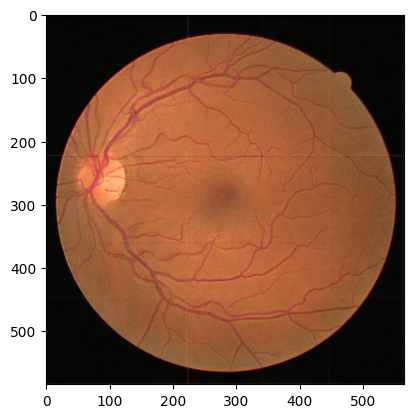

In [ ]:
plt.imshow(recs[0])
plt.show()

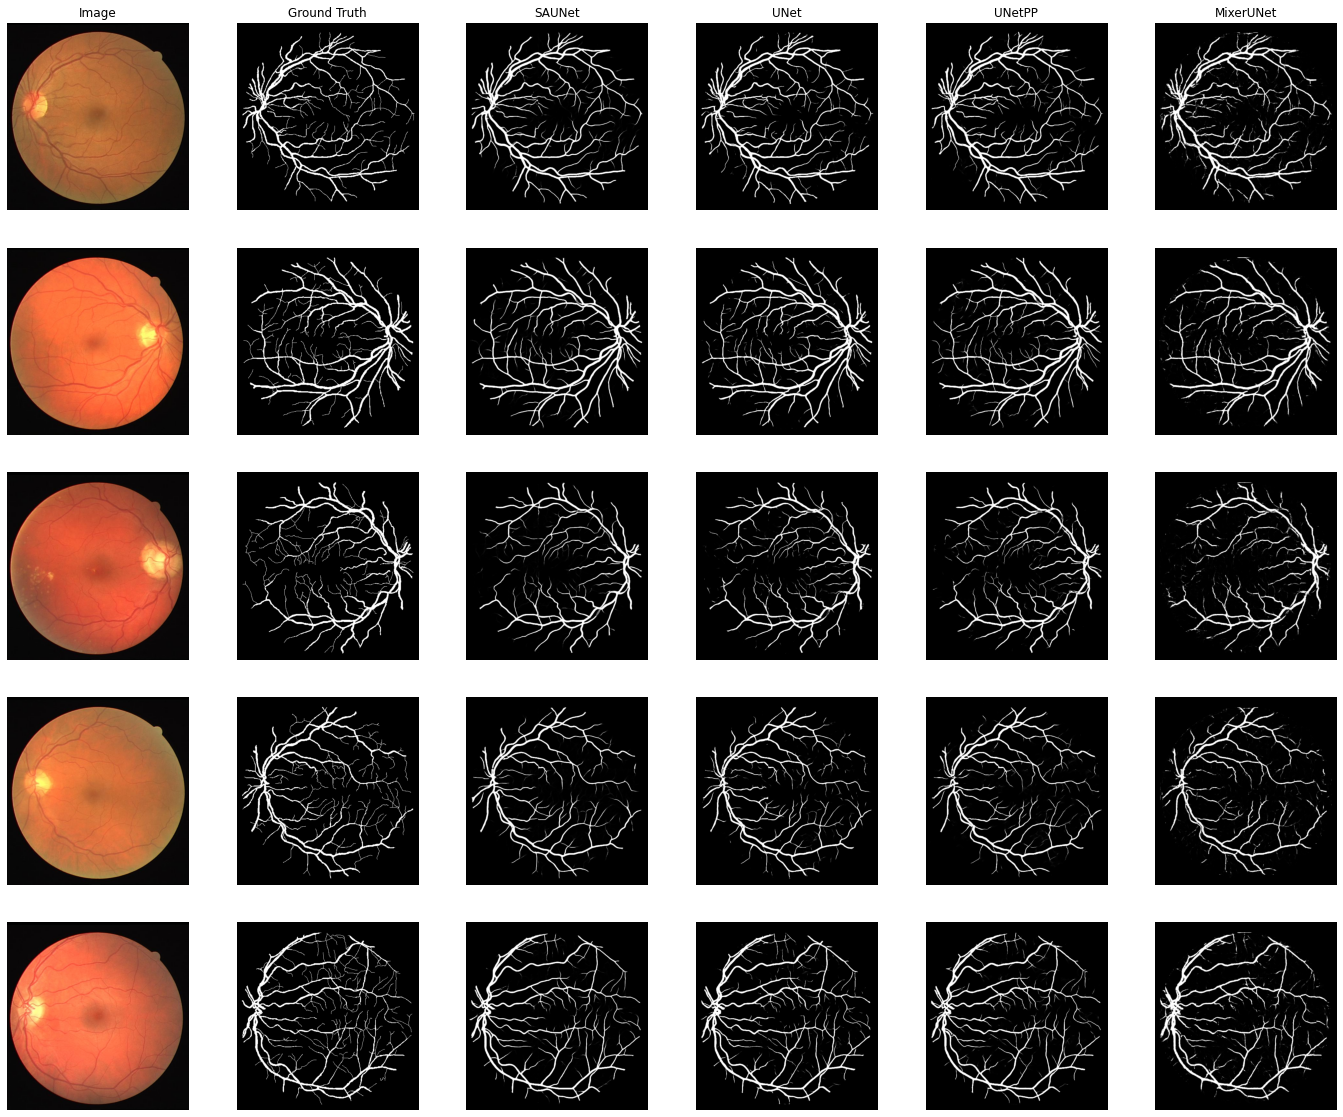

In [ ]:
columns = 6
rows = 5
fig = plt.figure(figsize=(24, 20))

labels = ["Image", "Ground Truth", "SAUNet", "UNet", "UNetPP", "MixerUNet"]

images = [
    '/content/drive/MyDrive/VesseslTest/DRIVE/Images/01.png',
    '/content/drive/MyDrive/VesseslTest/DRIVE/Images/02.png',
    '/content/drive/MyDrive/VesseslTest/DRIVE/Images/08.png',
    '/content/drive/MyDrive/VesseslTest/DRIVE/Images/09.png',
    '/content/drive/MyDrive/VesseslTest/DRIVE/Images/11.png'
]

masks = [
    '/content/drive/MyDrive/VesseslTest/DRIVE/Labels/01.png',
    '/content/drive/MyDrive/VesseslTest/DRIVE/Labels/02.png',
    '/content/drive/MyDrive/VesseslTest/DRIVE/Labels/08.png',
    '/content/drive/MyDrive/VesseslTest/DRIVE/Labels/09.png',
    '/content/drive/MyDrive/VesseslTest/DRIVE/Labels/11.png'
]

for i in range(1, columns*rows+1):
  fig.add_subplot(rows, columns, i)
  if i % 6 == 1:
    image = cv2.imread(images[i // 6])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
  elif i % 6 == 2:
    mask = cv2.imread(masks[i // 6])
    plt.imshow(mask)
    plt.axis('off')
  else:
    pred = results[labels[(i % 6) - 1]][(i - 1) // 6]
    plt.imshow(pred, cmap='gray')
    plt.axis('off')
  if i < 7:
    plt.title(labels[i - 1])
plt.show()
